# Pre-processing

In [1]:
!pip install mediapipe==0.10.9 opencv-python numpy==1.23.5 matplotlib scikit-learn

INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
  Using cached opencv_contrib_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
   ---------------------------------------- 0.0/50.5 MB ? eta -:--:--
   - -------------------------------------- 2.4/50.5 MB 15.0 MB/s eta 0:00:04
   ----- ---------------------------------- 6.8/50.5 MB 19.1 MB/s eta 0:00:03
   -------- ------------------------------- 10.5/50.5 MB 17.7 MB/s eta 0:00:03
   ---------- ----------------------------- 13.9/50.5 MB 17.5 MB/s eta 0:00:03
   -------------- ------------------------- 18.1/50.5 MB 17.6 MB/s eta 0:00:

In [1]:
import os
import cv2
import numpy as np
import mediapipe as mp

input_dir = r"C:\Users\SATYAM\Downloads\ssbd_dataset\ssbd2"   # dataset root
output_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed"
no_aug_dir = os.path.join(output_dir, "no_aug")
aug_dir = os.path.join(output_dir, "aug")
os.makedirs(no_aug_dir, exist_ok=True)
os.makedirs(aug_dir, exist_ok=True)


mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

def extract_skeleton(video_path, target_frames=150):
    """
    Extract 2D skeleton keypoints from a video using MediaPipe Pose.
    Returns: numpy array of shape [frames, 33, 2]
    """
    cap = cv2.VideoCapture(video_path)
    keypoints = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(rgb)

        if results.pose_landmarks:
            coords = [[lm.x, lm.y] for lm in results.pose_landmarks.landmark]
            keypoints.append(coords)

    cap.release()

    if len(keypoints) == 0:
        return None

    data = np.array(keypoints)

    # Normalize skeleton
    mean = np.mean(data, axis=(0, 1))
    std = np.std(data, axis=(0, 1)) + 1e-6
    data = (data - mean) / std

    # Segment or pad to fixed length
    if len(data) > target_frames:
        data = data[:target_frames]
    elif len(data) < target_frames:
        pad = np.zeros((target_frames - len(data), 33, 2))
        data = np.concatenate([data, pad], axis=0)

    return data


def augment_skeleton(skeleton):
    """Apply mirroring, temporal jitter, and Gaussian noise."""
    mirrored = skeleton.copy()
    mirrored[:, :, 0] *= -1
    jitter = np.roll(skeleton, shift=np.random.randint(-5, 6), axis=0)
    noise = skeleton + np.random.normal(0, 0.05, skeleton.shape)
    return np.stack([mirrored, jitter, noise], axis=0)


class_map = {"spinning": 1, "headBanging": 1, "armFlapping": 1}  # ASD = 1

for cls in os.listdir(input_dir):
    class_path = os.path.join(input_dir, cls)
    if not os.path.isdir(class_path):
        continue

    nested_class_path = os.path.join(class_path, cls)  # handle nested folder
    if not os.path.isdir(nested_class_path):
        continue

    print(f"Processing class: {cls}")

    # create class folders in aug/no_aug
    os.makedirs(os.path.join(no_aug_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(aug_dir, cls), exist_ok=True)

    for vid in os.listdir(nested_class_path):
        if not vid.endswith(".mp4"):
            continue
        vid_path = os.path.join(nested_class_path, vid)
        skeleton = extract_skeleton(vid_path)

        if skeleton is None:
            print(f"❌ No skeleton detected in {vid}")
            continue

        # Save original
        np.save(os.path.join(no_aug_dir, cls, vid.replace(".mp4", ".npy")), skeleton)

        # Save augmented
        augmented = augment_skeleton(skeleton)
        for i, aug in enumerate(augmented, start=1):
            np.save(os.path.join(aug_dir, cls, vid.replace(".mp4", f"_aug{i}.npy")), aug)

print("✅ Dataset prepared with no_aug and aug subfolders!")

def load_npy_data(base_dir):
    X, y = [], []
    for cls in os.listdir(base_dir):
        class_folder = os.path.join(base_dir, cls)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            if file.endswith(".npy"):
                X.append(np.load(os.path.join(class_folder, file)))
                y.append(cls)  # can later convert to integer label
    return np.array(X), np.array(y)


X_no_aug, y_no_aug = load_npy_data(no_aug_dir)
X_aug, y_aug = load_npy_data(aug_dir)
print("Shapes:", X_no_aug.shape, X_aug.shape)

Processing class: armFlapping
Processing class: headBanging
Processing class: spinning
✅ Dataset prepared with no_aug and aug subfolders!
Shapes: (183, 150, 33, 2) (549, 150, 33, 2)


In [1]:
#Loading the dataset
import os
import numpy as np

output_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed"
no_aug_dir = os.path.join(output_dir, "no_aug")
aug_dir = os.path.join(output_dir, "aug")

def load_npy_data(base_dir):
    X, y = [], []
    for cls in os.listdir(base_dir):
        class_folder = os.path.join(base_dir, cls)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            if file.endswith(".npy"):
                X.append(np.load(os.path.join(class_folder, file)))
                y.append(cls)
    return np.array(X), np.array(y)

X_no_aug, y_no_aug = load_npy_data(no_aug_dir)
X_aug, y_aug = load_npy_data(aug_dir)

print("Shapes:")
print("No augmentation:", X_no_aug.shape)
print("With augmentation:", X_aug.shape)

Shapes:
No augmentation: (183, 150, 33, 2)
With augmentation: (549, 150, 33, 2)


# Model training

Combined X shape: (732, 150, 33, 2)
Combined y shape: (732,)
Before reshape → X_train: (585, 150, 33, 2)  | X_test: (147, 150, 33, 2)
After reshape → X_train: (585, 150, 66)  | X_test: (147, 150, 66)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, 150, 66)           0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               99840     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                    

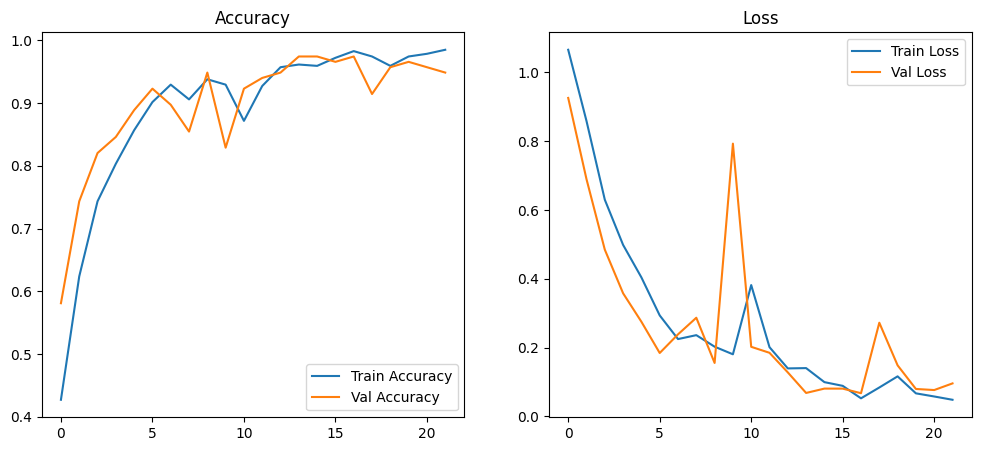

5/5 [==============================] - 0s 37ms/step - loss: 0.0556 - accuracy: 0.9660

🧪 Final Test Accuracy: 96.60%


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Combine both
X = np.concatenate([X_no_aug, X_aug], axis=0)
y = np.concatenate([y_no_aug, y_aug], axis=0)

print("Combined X shape:", X.shape)
print("Combined y shape:", y.shape)

# ================================
# 🔤 Encode labels
# ================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)
num_classes = y_cat.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)
print("Before reshape → X_train:", X_train.shape, " | X_test:", X_test.shape)

# ================================
# 🔁 Flatten keypoints + coords → for LSTM (timesteps, features)
# ================================
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3]))

print("After reshape → X_train:", X_train.shape, " | X_test:", X_test.shape)
# Expected: (samples, 150, 66)

# ================================
# 🏗️ Model Architecture — LSTM
# ================================
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# ================================
# 🚀 Training
# ================================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# ================================
# 📈 Plot Training vs Validation
# ================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

# ================================
# 🧪 Evaluate on Test Data
# ================================
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n🧪 Final Test Accuracy: {test_acc*100:.2f}%")
model.save("LSTM_skeletons.h5")

Combined X shape: (732, 150, 33, 2)
Combined y shape: (732,)
Before reshape → X_train: (585, 150, 33, 2)  | X_test: (147, 150, 33, 2)
After reshape → X_train: (585, 150, 66)  | X_test: (147, 150, 66)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 150, 66)           0         
                                                                 
 lstm (LSTM)                 (None, 128)               99840     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                    

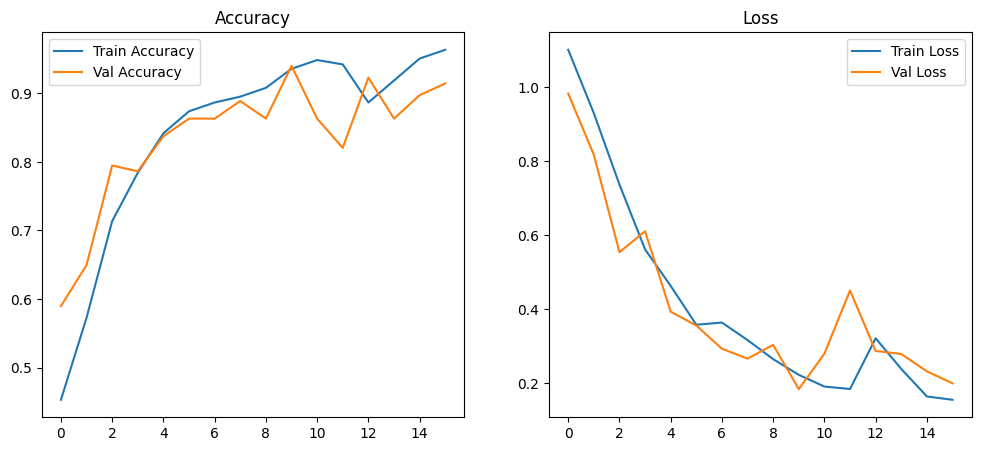

5/5 [==============================] - 0s 40ms/step - loss: 0.1867 - accuracy: 0.9388

🧪 Final Test Accuracy: 93.88%
✅ Model saved as LSTM_regularized_skeletons.h5


In [5]:
# ================================
# 📦 Imports
# ================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# ================================
# 🧠 Load both augmented and non-augmented data
# ================================
X = np.concatenate([X_no_aug, X_aug], axis=0)
y = np.concatenate([y_no_aug, y_aug], axis=0)

print("Combined X shape:", X.shape)
print("Combined y shape:", y.shape)

# ================================
# 🔤 Encode labels
# ================================
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)
num_classes = y_cat.shape[1]

# ================================
# 🔀 Train-test split
# ================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)
print("Before reshape → X_train:", X_train.shape, " | X_test:", X_test.shape)

# ================================
# 🔁 Flatten keypoints + coords → for LSTM (timesteps, features)
# ================================
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2] * X_train.shape[3]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2] * X_test.shape[3]))

print("After reshape → X_train:", X_train.shape, " | X_test:", X_test.shape)
# Expected: (samples, 150, 66)

# ================================
# 🏗️ Model Architecture — LSTM with Regularization
# ================================
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),

    # L2 regularization added in LSTM
    LSTM(128, return_sequences=False, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.4),

    # Dense layer with L2 regularization
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend(); plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Loss')
plt.show()

# ================================
# 🧪 Evaluate on Test Data
# ================================
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n🧪 Final Test Accuracy: {test_acc*100:.2f}%")

model.save("LSTM_regularized_skeletons.h5")
print("✅ Model saved as LSTM_regularized_skeletons.h5")

5/5 [==============================] - 2s 38ms/step

Classification Report:
               precision    recall  f1-score   support

 armFlapping       0.94      0.96      0.95        46
 headBanging       0.96      0.94      0.95        50
    spinning       1.00      1.00      1.00        51

    accuracy                           0.97       147
   macro avg       0.97      0.97      0.97       147
weighted avg       0.97      0.97      0.97       147



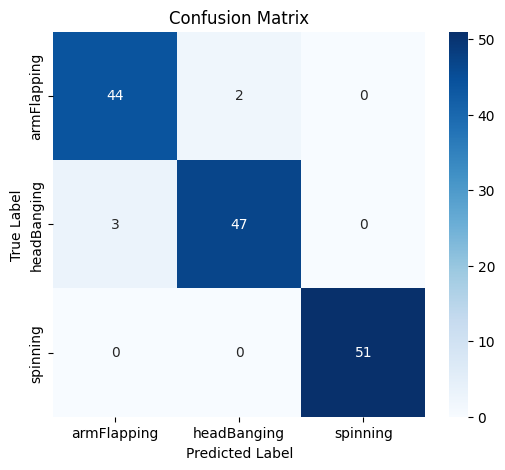

In [7]:
# ================================
# 🧾 Classification Report
# ================================
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:\n", classification_report(y_true_labels, y_pred_labels, target_names=le.classes_))
# ================================
# 🧩 Confusion Matrix (optional visualization)
# ================================
import seaborn as sns
import pandas as pd


cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(pd.DataFrame(cm, index=le.classes_, columns=le.classes_), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Combined X shape: (732, 150, 33, 2)
Combined y shape: (732,)
Reshaped X: (732, 150, 66)
Train set: (585, 150, 66) (585, 3)
Test set: (147, 150, 66) (147, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 150, 256)         199680    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 150, 256)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             

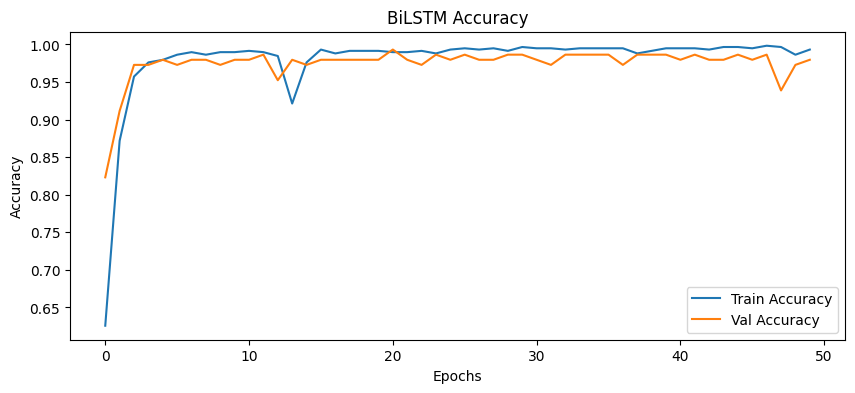

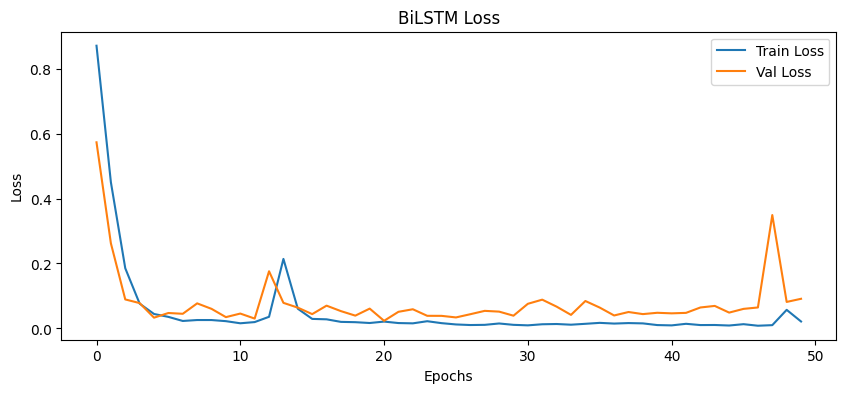

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# ==================================
# Combine Datasets
# ==================================
X = np.concatenate((X_no_aug, X_aug), axis=0)
y = np.concatenate((y_no_aug, y_aug), axis=0)

print("Combined X shape:", X.shape)
print("Combined y shape:", y.shape)

# ==================================
# Reshape & Scale Features
# ==================================
# Flatten last two dims: (33, 2) → (66)
X_reshaped = X.reshape(X.shape[0], X.shape[1], -1)
print("Reshaped X:", X_reshaped.shape)

# Scale features
scaler = StandardScaler()
n_samples, n_timesteps, n_features = X_reshaped.shape
X_scaled = scaler.fit_transform(X_reshaped.reshape(-1, n_features))
X_scaled = X_scaled.reshape(n_samples, n_timesteps, n_features)

# Save scaler for future inference
joblib.dump(scaler, "bilstm_scaler.pkl")

import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encode and one-hot
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y = to_categorical(y_encoded, num_classes=len(np.unique(y_encoded)))

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, shuffle=True
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

# ==================================
# Define BiLSTM Model
# ==================================
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True), input_shape=(n_timesteps, n_features)),
    Dropout(0.3),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

# ==================================
# Evaluate Model
# ==================================
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

model.save("bilstm_model.h5")
print("\n💾 Model saved successfully as 'bilstm_model.h5'")

# ==========================
# Plot Training Curves
# ==========================
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('BiLSTM Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BiLSTM Loss')
plt.legend()
plt.show()


5/5 [==============================] - 2s 77ms/step


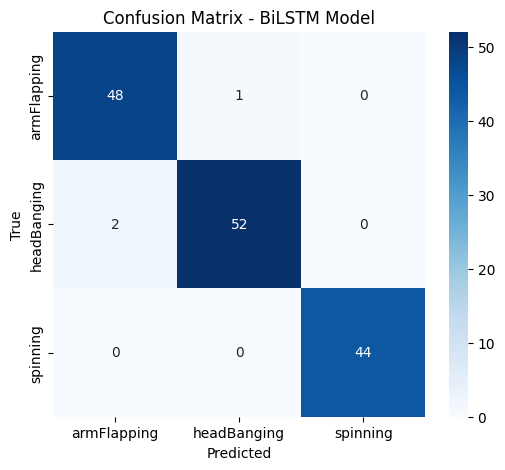


Classification Report:

              precision    recall  f1-score   support

 armFlapping       0.96      0.98      0.97        49
 headBanging       0.98      0.96      0.97        54
    spinning       1.00      1.00      1.00        44

    accuracy                           0.98       147
   macro avg       0.98      0.98      0.98       147
weighted avg       0.98      0.98      0.98       147



In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
classes = le.classes_  # from LabelEncoder

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - BiLSTM Model")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

Train shape: (585, 150, 66)
Test shape: (147, 150, 66)
Epoch 1/30
30/30 [==============================] - 5s 56ms/step - loss: 0.9808 - accuracy: 0.5385 - val_loss: 0.8384 - val_accuracy: 0.6496
Epoch 2/30
30/30 [==============================] - 1s 30ms/step - loss: 0.6659 - accuracy: 0.7372 - val_loss: 0.5365 - val_accuracy: 0.7863
Epoch 3/30
30/30 [==============================] - 1s 31ms/step - loss: 0.4551 - accuracy: 0.8141 - val_loss: 0.5649 - val_accuracy: 0.7949
Epoch 4/30
30/30 [==============================] - 1s 29ms/step - loss: 0.5149 - accuracy: 0.8034 - val_loss: 0.4215 - val_accuracy: 0.8034
Epoch 5/30
30/30 [==============================] - 1s 31ms/step - loss: 0.3586 - accuracy: 0.8697 - val_loss: 0.4018 - val_accuracy: 0.8376
Epoch 6/30
30/30 [==============================] - 1s 33ms/step - loss: 0.2736 - accuracy: 0.8718 - val_loss: 0.2536 - val_accuracy: 0.8889
Epoch 7/30
30/30 [==============================] - 1s 30ms/step - loss: 0.2176 - accuracy: 0.9081 

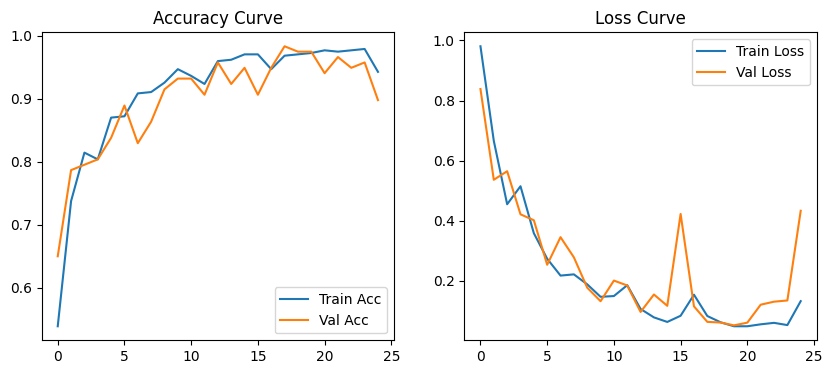

5/5 [==============================] - 1s 19ms/step


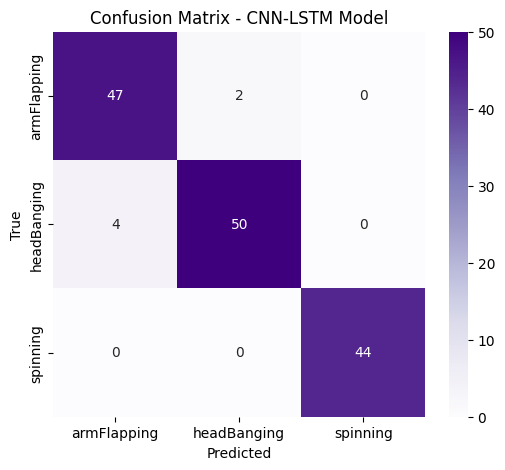


Classification Report:

              precision    recall  f1-score   support

 armFlapping       0.92      0.96      0.94        49
 headBanging       0.96      0.93      0.94        54
    spinning       1.00      1.00      1.00        44

    accuracy                           0.96       147
   macro avg       0.96      0.96      0.96       147
weighted avg       0.96      0.96      0.96       147

💾 Model saved as cnn_lstm_model.h5


In [11]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Data Preparation
# =========================
# Flatten last two dims (33, 2) into a single feature vector per frame
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

print("Train shape:", X_train_flat.shape)
print("Test shape:", X_test_flat.shape)

# =========================
# Model Definition
# =========================
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train_flat.shape[1], X_train_flat.shape[2])),
    MaxPooling1D(2),
    Dropout(0.3),
    
    Conv1D(128, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.3),
    
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(np.argmax(y_train, axis=1))), activation='softmax')
])

# =========================
# Compile Model
# =========================
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# =========================
# Train Model
# =========================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_flat, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Evaluate on Test Data
# =========================
test_loss, test_acc = model.evaluate(X_test_flat, y_test)
print(f"🧪 Final Test Accuracy: {test_acc*100:.2f}%")

# =========================
# Plot Training Curves
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()

# =========================
# Confusion Matrix + Report
# =========================
y_pred_probs = model.predict(X_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
classes = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN-LSTM Model")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# =========================
# Save Model
# =========================
model.save("cnn_lstm_model.h5")
print("💾 Model saved as cnn_lstm_model.h5")

In [3]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Paths (update if needed)
no_aug_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed\no_aug"
aug_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed\aug"

# Loader function
def load_npy_data(base_dir):
    X, y = [], []
    for cls in os.listdir(base_dir):
        class_folder = os.path.join(base_dir, cls)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            if file.endswith(".npy"):
                X.append(np.load(os.path.join(class_folder, file)))
                y.append(cls)
    return np.array(X), np.array(y)

# Load both folders
X_no_aug, y_no_aug = load_npy_data(no_aug_dir)
X_aug, y_aug = load_npy_data(aug_dir)

print("Loaded shapes:")
print("  X_no_aug:", X_no_aug.shape)
print("  X_aug:", X_aug.shape)

# Combine augmented + non-augmented data
X = np.concatenate([X_no_aug, X_aug], axis=0)
y = np.concatenate([y_no_aug, y_aug], axis=0)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print("✅ Data loaded and split!")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


Loaded shapes:
  X_no_aug: (183, 150, 33, 2)
  X_aug: (549, 150, 33, 2)
✅ Data loaded and split!
X_train: (585, 150, 33, 2) y_train: (585, 3)
X_test: (147, 150, 33, 2) y_test: (147, 3)


Train shape: (585, 150, 66)
Test shape: (147, 150, 66)
Epoch 1/30
30/30 [==============================] - 49s 699ms/step - loss: 1.0990 - accuracy: 0.4274 - val_loss: 1.0164 - val_accuracy: 0.4274
Epoch 2/30
30/30 [==============================] - 11s 377ms/step - loss: 0.9297 - accuracy: 0.5684 - val_loss: 0.7947 - val_accuracy: 0.7179
Epoch 3/30
30/30 [==============================] - 11s 380ms/step - loss: 0.7905 - accuracy: 0.6603 - val_loss: 0.6973 - val_accuracy: 0.7009
Epoch 4/30
30/30 [==============================] - 11s 381ms/step - loss: 0.6973 - accuracy: 0.7073 - val_loss: 0.5928 - val_accuracy: 0.7350
Epoch 5/30
30/30 [==============================] - 10s 327ms/step - loss: 0.5520 - accuracy: 0.7650 - val_loss: 0.6269 - val_accuracy: 0.7607
Epoch 6/30
30/30 [==============================] - 9s 313ms/step - loss: 0.4611 - accuracy: 0.8333 - val_loss: 0.4464 - val_accuracy: 0.7949
Epoch 7/30
30/30 [==============================] - 10s 327ms/step - loss: 0.3880 - accu

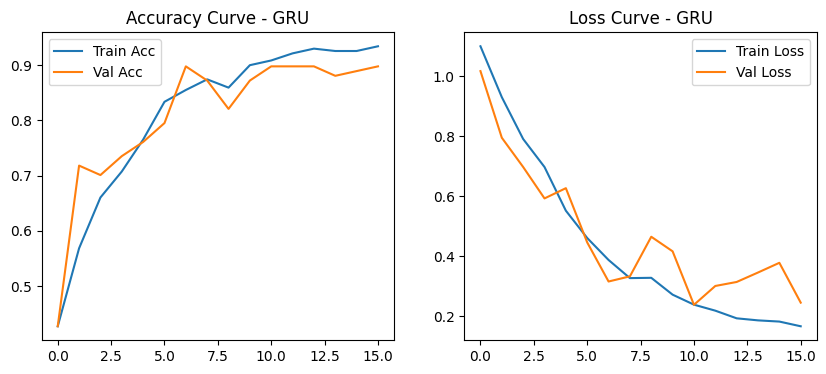

5/5 [==============================] - 8s 127ms/step


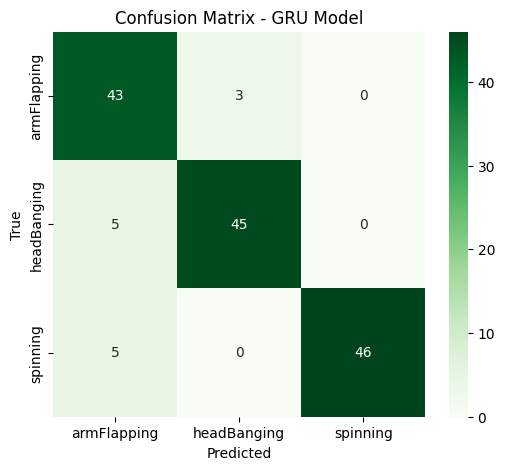


Classification Report:

              precision    recall  f1-score   support

 armFlapping       0.81      0.93      0.87        46
 headBanging       0.94      0.90      0.92        50
    spinning       1.00      0.90      0.95        51

    accuracy                           0.91       147
   macro avg       0.92      0.91      0.91       147
weighted avg       0.92      0.91      0.91       147

💾 Model saved as gru_model.h5


In [4]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Data Preparation
# =========================
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

print("Train shape:", X_train_flat.shape)
print("Test shape:", X_test_flat.shape)

# =========================
# Model Definition
# =========================
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train_flat.shape[1], X_train_flat.shape[2])),
    GRU(128, return_sequences=True),
    Dropout(0.3),
    GRU(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(np.unique(np.argmax(y_train, axis=1))), activation='softmax')
])

# =========================
# Compile Model
# =========================
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# =========================
# Train Model
# =========================
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_flat, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Evaluate on Test Data
# =========================
test_loss, test_acc = model.evaluate(X_test_flat, y_test)
print(f"🧪 Final Test Accuracy: {test_acc*100:.2f}%")

# =========================
# Plot Training Curves
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - GRU")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - GRU")
plt.legend()
plt.show()

# =========================
# Confusion Matrix + Report
# =========================
y_pred_probs = model.predict(X_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
classes = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU Model")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# =========================
# Save Model
# =========================
model.save("gru_model.h5")
print("💾 Model saved as gru_model.h5")


Train shape: (585, 150, 66)
Test shape: (147, 150, 66)
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, 150, 66)           0         
                                                                 
 gru (GRU)                   (None, 150, 128)          75264     
                                                                 
 dropout_6 (Dropout)         (None, 150, 128)          0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 

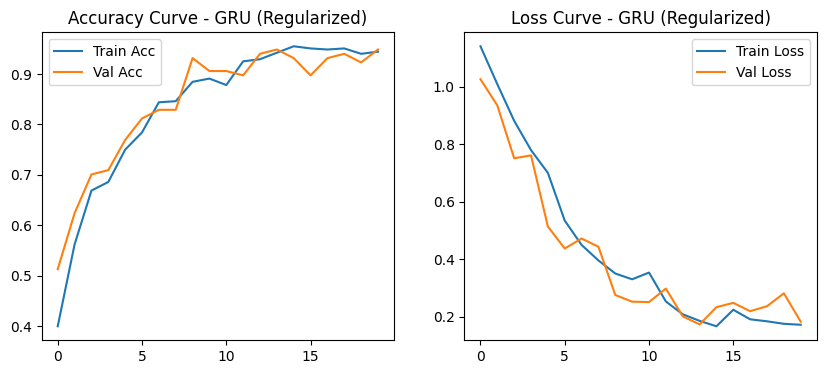

5/5 [==============================] - 3s 40ms/step


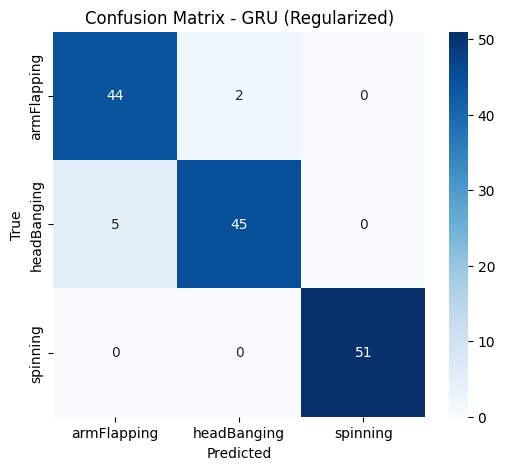


Classification Report:

              precision    recall  f1-score   support

 armFlapping       0.90      0.96      0.93        46
 headBanging       0.96      0.90      0.93        50
    spinning       1.00      1.00      1.00        51

    accuracy                           0.95       147
   macro avg       0.95      0.95      0.95       147
weighted avg       0.95      0.95      0.95       147

✅ Model saved as GRU_regularized_model.h5


In [8]:
# =========================
# 📦 Imports
# =========================
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# 🧠 Data Preparation
# =========================
X_train_flat = X_train.reshape(X_train.shape[0], X_train.shape[1], -1)
X_test_flat  = X_test.reshape(X_test.shape[0], X_test.shape[1], -1)

print("Train shape:", X_train_flat.shape)
print("Test shape:", X_test_flat.shape)

# =========================
# 🏗️ Model Definition — GRU with Regularization
# =========================
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train_flat.shape[1], X_train_flat.shape[2])),

    # Add L2 regularization in GRU layers
    GRU(128, return_sequences=True, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.4),

    GRU(64, kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),

    Dense(len(np.unique(np.argmax(y_train, axis=1))), activation='softmax')
])

# =========================
# ⚙️ Compile Model
# =========================
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

# =========================
# 🚀 Train Model
# =========================
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    X_train_flat, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# 🧪 Evaluate on Test Data
# =========================
test_loss, test_acc = model.evaluate(X_test_flat, y_test)
print(f"🧪 Final Test Accuracy: {test_acc*100:.2f}%")

# =========================
# 📈 Plot Training Curves
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - GRU (Regularized)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - GRU (Regularized)")
plt.legend()
plt.show()

# =========================
# 🔍 Confusion Matrix + Report
# =========================
y_pred_probs = model.predict(X_test_flat)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
classes = le.classes_

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU (Regularized)")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# =========================
# 💾 Save Model
# =========================
model.save("GRU_regularized_model.h5")
print("✅ Model saved as GRU_regularized_model.h5")


3D CNN Train shape: (585, 150, 33, 2, 1)
3D CNN Test shape: (147, 150, 33, 2, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 150, 33, 2, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 150, 17, 1, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 150, 17, 1, 32)   128       
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 150, 17, 1, 64)    55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 9, 1, 64)     0         
 3D)                                     

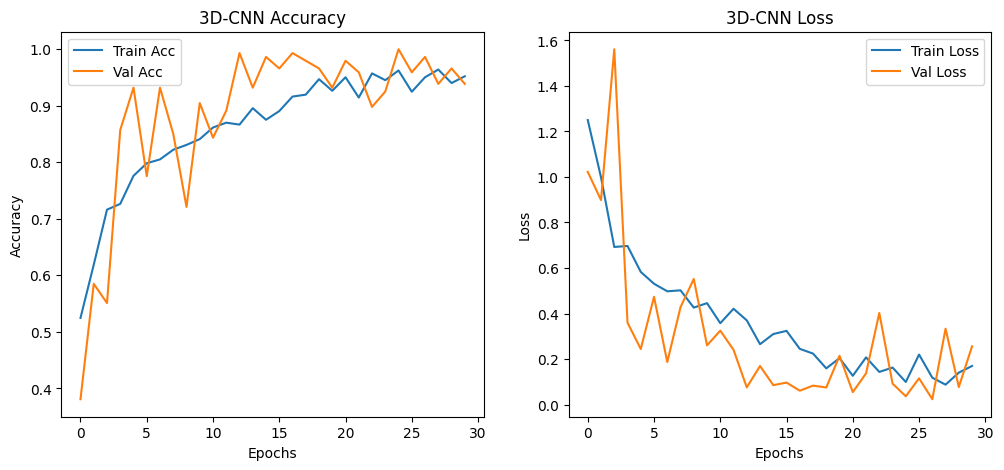

5/5 [==============================] - 2s 262ms/step


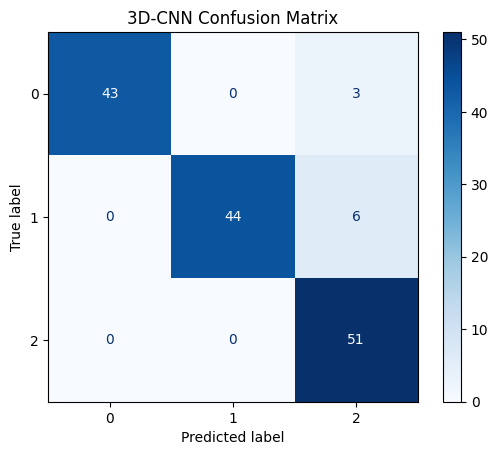

In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ===========================================
# 🔹 Step 1: Reshape and Prepare Data
# ===========================================
# 3D CNN expects (samples, frames, height, width, channels)
# Currently we have (samples, 150, 33, 2)
# We'll treat 150 as frames, 33 as height, and 2 as width, so we need to add a channel dimension
X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3], 1))
X_test_3d  = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], X_test.shape[3], 1))

print("3D CNN Train shape:", X_train_3d.shape)
print("3D CNN Test shape:", X_test_3d.shape)

num_classes = y_train.shape[1]

# ===========================================
# 🔹 Step 2: Build 3D-CNN Model
# ===========================================
def build_3d_cnn(input_shape, num_classes):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.MaxPooling3D((1, 2, 2), padding='same'),
        layers.BatchNormalization(),

        # Conv Block 2
        layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D((2, 2, 2), padding='same'),
        layers.BatchNormalization(),

        # Conv Block 3
        layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D((2, 2, 2), padding='same'),
        layers.BatchNormalization(),

        # Conv Block 4
        layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same'),
        layers.GlobalAveragePooling3D(),
        layers.Dropout(0.5),

        # Dense Layers
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = X_train_3d.shape[1:]
model_3dcnn = build_3d_cnn(input_shape, num_classes)
model_3dcnn.summary()

# ===========================================
# 🔹 Step 3: Train Model
# ===========================================
history = model_3dcnn.fit(
    X_train_3d, y_train,
    validation_data=(X_test_3d, y_test),
    epochs=30,
    batch_size=4,
    verbose=1
)

# ===========================================
# 🔹 Step 4: Save Model
# ===========================================
model_3dcnn.save("3dcnn_model.h5")
print("✅ Model saved as 3dcnn_model.h5")

# ===========================================
# 🔹 Step 5: Evaluate Model
# ===========================================
test_loss, test_acc = model_3dcnn.evaluate(X_test_3d, y_test)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

# ===========================================
# 🔹 Step 6: Plot Accuracy and Loss
# ===========================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('3D-CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('3D-CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# ===========================================
# 🔹 Step 7: Confusion Matrix
# ===========================================
y_pred = np.argmax(model_3dcnn.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("3D-CNN Confusion Matrix")
plt.show()

3D CNN Train shape: (585, 150, 66, 1, 1)
3D CNN Test shape: (147, 150, 66, 1, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 150, 66, 1, 32)    896       
                                                                 
 batch_normalization_3 (Batc  (None, 150, 66, 1, 32)   128       
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 150, 33, 1, 32)   0         
 3D)                                                             
                                                                 
 conv3d_5 (Conv3D)           (None, 150, 33, 1, 64)    55360     
                                                                 
 batch_normalization_4 (Batc  (None, 150, 33, 1, 64)   256       
 hNormalization)                       

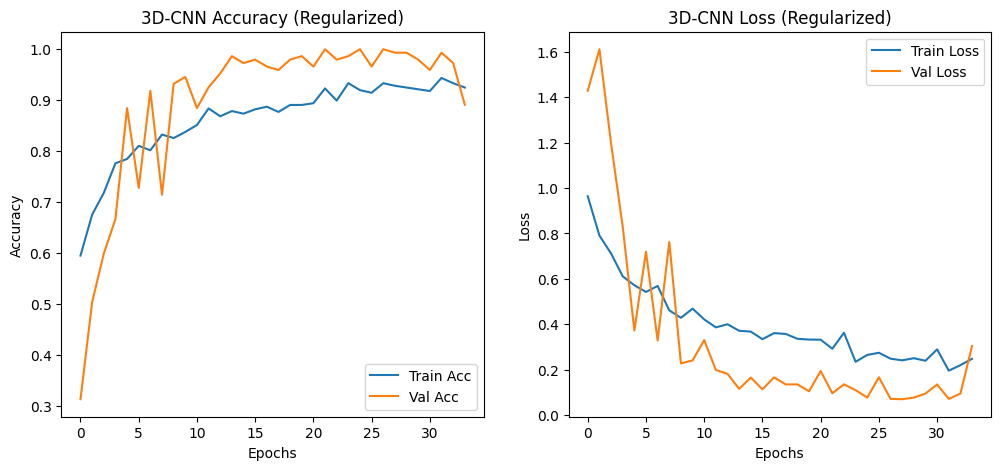

5/5 [==============================] - 5s 963ms/step


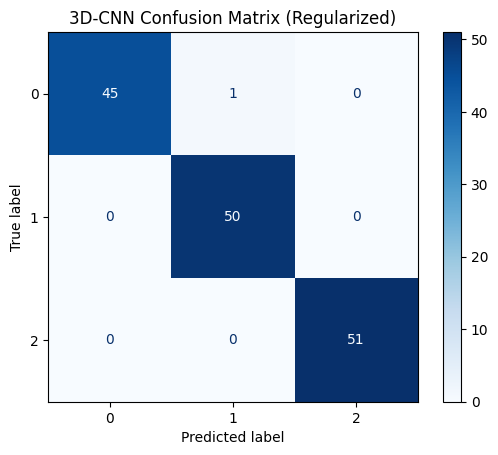

In [11]:
# ===========================================
# 📦 Imports
# ===========================================
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ===========================================
# 🔹 Step 1: Reshape and Prepare Data
# ===========================================
X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1, 1))
X_test_3d  = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1, 1))


print("3D CNN Train shape:", X_train_3d.shape)
print("3D CNN Test shape:", X_test_3d.shape)

num_classes = y_train.shape[1]

# ===========================================
# 🔹 Step 2: Build Regularized 3D-CNN Model
# ===========================================
def build_3d_cnn_regularized(input_shape, num_classes):
    l2_reg = regularizers.l2(1e-4)  # small L2 penalty

    model = models.Sequential([
        # Conv Block 1
        layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same',
                      kernel_regularizer=l2_reg, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling3D((1, 2, 2), padding='same'),

        # Conv Block 2
        layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2), padding='same'),
        layers.Dropout(0.3),

        # Conv Block 3
        layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2, 2, 2), padding='same'),
        layers.Dropout(0.4),

        # Conv Block 4
        layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling3D(),
        layers.Dropout(0.5),

        # Dense Layers
        layers.Dense(512, activation='relu', kernel_regularizer=l2_reg),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = X_train_3d.shape[1:]
model_3dcnn = build_3d_cnn_regularized(input_shape, num_classes)
model_3dcnn.summary()

# ===========================================
# 🔹 Step 3: Train Model (with Early Stopping)
# ===========================================
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model_3dcnn.fit(
    X_train_3d, y_train,
    validation_data=(X_test_3d, y_test),
    epochs=40,
    batch_size=4,
    callbacks=[early_stop],
    verbose=1
)

# ===========================================
# 🔹 Step 4: Save Model
# ===========================================
model_3dcnn.save("3dcnn_regularized_model.h5")
print("✅ Model saved as 3dcnn_regularized_model.h5")

# ===========================================
# 🔹 Step 5: Evaluate Model
# ===========================================
test_loss, test_acc = model_3dcnn.evaluate(X_test_3d, y_test)
print(f"\n🧪 Test Accuracy: {test_acc * 100:.2f}%")

# ===========================================
# 🔹 Step 6: Plot Accuracy and Loss
# ===========================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('3D-CNN Accuracy (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('3D-CNN Loss (Regularized)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# ===========================================
# 🔹 Step 7: Confusion Matrix
# ===========================================
y_pred = np.argmax(model_3dcnn.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("3D-CNN Confusion Matrix (Regularized)")
plt.show()


Combined dataset: (732, 150, 33, 2) (732,)
Train: (585, 150, 66) Test: (147, 150, 66)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 66)]    0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 150, 66)     132         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 150, 66)     68418       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
        

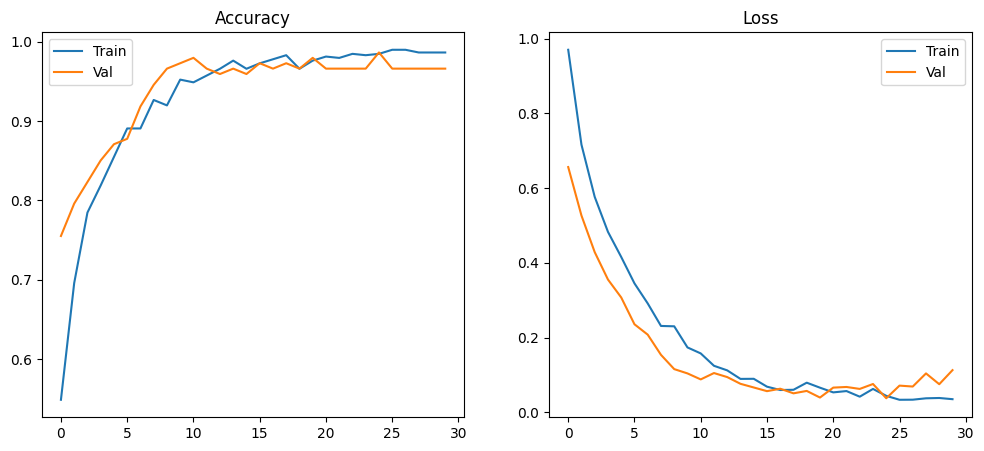

5/5 [==============================] - 1s 138ms/step


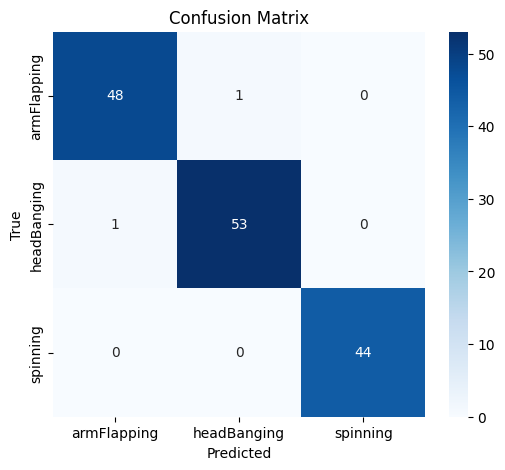


Classification Report:
               precision    recall  f1-score   support

 armFlapping       0.98      0.98      0.98        49
 headBanging       0.98      0.98      0.98        54
    spinning       1.00      1.00      1.00        44

    accuracy                           0.99       147
   macro avg       0.99      0.99      0.99       147
weighted avg       0.99      0.99      0.99       147

✅ Transformer model saved as transformer_asd_model.h5


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ======================================================
# 1️⃣ Load Data (from your previously saved .npy files)
# ======================================================
no_aug_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed\no_aug"
aug_dir    = r"C:\Users\SATYAM\Downloads\ssbd_processed\aug"

def load_npy_data(base_dir):
    X, y = [], []
    for cls in os.listdir(base_dir):
        class_folder = os.path.join(base_dir, cls)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            if file.endswith(".npy"):
                X.append(np.load(os.path.join(class_folder, file)))
                y.append(cls)
    return np.array(X), np.array(y)

X_no_aug, y_no_aug = load_npy_data(no_aug_dir)
X_aug, y_aug = load_npy_data(aug_dir)

# Combine both
X = np.concatenate([X_no_aug, X_aug], axis=0)
y = np.concatenate([y_no_aug, y_aug], axis=0)

print("Combined dataset:", X.shape, y.shape)

# ======================================================
# 2️⃣ Preprocess Data
# ======================================================
# Flatten joints per frame: (150, 33, 2) -> (150, 66)
X = X.reshape(X.shape[0], X.shape[1], -1)

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)
print("Train:", X_train.shape, "Test:", X_test.shape)

# ======================================================
# 3️⃣ Define Transformer Encoder Block
# ======================================================
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Dense(ff_dim, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return x + res

# ======================================================
# 4️⃣ Build Transformer Model
# ======================================================
input_shape = X_train.shape[1:]
inputs = layers.Input(shape=input_shape)

x = inputs
for _ in range(3):  # 3 Transformer blocks
    x = transformer_encoder(x, head_size=64, num_heads=4, ff_dim=128, dropout=0.2)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(y_train.shape[1], activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=["accuracy"]
)

model.summary()

# ======================================================
# 5️⃣ Train the Model
# ======================================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# ======================================================
# 6️⃣ Evaluate and Visualize
# ======================================================
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"🧪 Test Accuracy: {test_acc*100:.2f}%")

# Plot accuracy & loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend(); plt.title("Loss")
plt.show()

# ======================================================
# 7️⃣ Confusion Matrix
# ======================================================
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n", classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# ======================================================
# 8️⃣ Save Model
# ======================================================
model.save("transformer_asd_model.h5")
print("✅ Transformer model saved as transformer_asd_model.h5")

# COMPARATIVE ANALYSIS


🔹 Evaluating LSTM ...
5/5 [==============================] - 2s 52ms/step
✅ LSTM — Accuracy: 93.88%, F1: 93.80%

🔹 Evaluating BiLSTM ...
5/5 [==============================] - 4s 119ms/step
✅ BiLSTM — Accuracy: 68.71%, F1: 65.34%

🔹 Evaluating CNN-LSTM ...
5/5 [==============================] - 1s 22ms/step
✅ CNN-LSTM — Accuracy: 87.07%, F1: 87.34%

🔹 Evaluating GRU ...
5/5 [==============================] - 3s 62ms/step
✅ GRU — Accuracy: 95.24%, F1: 95.14%

🔹 Evaluating Transformer ...
5/5 [==============================] - 1s 169ms/step
✅ Transformer — Accuracy: 98.64%, F1: 98.61%

🔹 Evaluating ST-GCN ...
❌ Error loading ST-GCN: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x00000164BB3A65C0>.

🔹 Evaluating 3D-CNN ...
❌ Error loading 3D-CNN: in user code:

    File "C:\Users\SATYAM\anaconda3\envs\mp_env\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Use

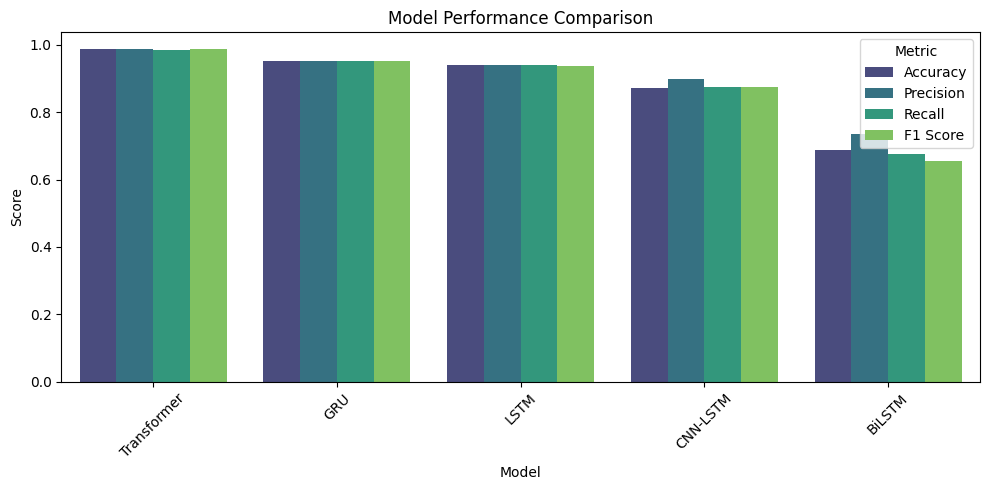

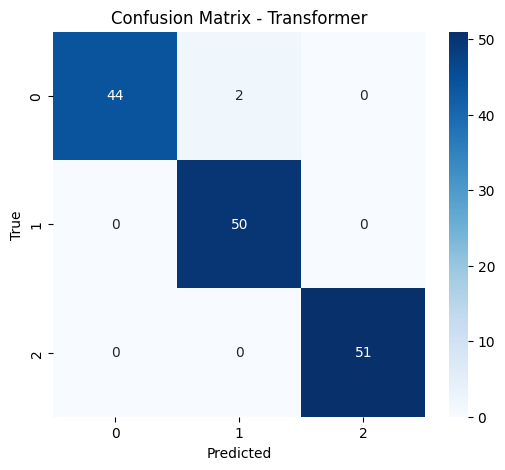

In [12]:
# ===========================================
# 📦 IMPORTS
# ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

# ===========================================
# 🧩 LOAD DATA
# ===========================================
# Make sure these are the same data splits used for all models
# Replace with your correct test arrays
X_test_data = X_test  # or X_test_flat / X_test_3d / graph_format if specific per model
y_test_data = y_test

# ===========================================
# 🧾 DEFINE MODEL PATHS
# ===========================================
model_paths = {
    "LSTM": "LSTM_regularized_skeletons.h5",
    "BiLSTM": "BiLSTM_model.h5",
    "CNN-LSTM": "cnn_lstm_model.h5",
    "GRU": "GRU_regularized_model.h5",
    "Transformer": "transformer_asd_model.h5",
    "ST-GCN": "stgcn_model.h5",
    "3D-CNN": "3dcnn_regularized_model.h5"
}

# ===========================================
# ⚙️ EVALUATION FUNCTION
# ===========================================
def evaluate_model(model, X_test, y_test):
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
    rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm,
        "report": report
    }

# ===========================================
# 🧮 EVALUATE ALL MODELS
# ===========================================
results = {}
for name, path in model_paths.items():
    try:
        print(f"\n🔹 Evaluating {name} ...")
        model = load_model(path)
        metrics = evaluate_model(model, X_test_data, y_test_data)
        results[name] = metrics
        print(f"✅ {name} — Accuracy: {metrics['accuracy']*100:.2f}%, F1: {metrics['f1']*100:.2f}%")
    except Exception as e:
        print(f"❌ Error loading {name}: {e}")

# ===========================================
# 📊 COMPARISON TABLE
# ===========================================
comparison_df = pd.DataFrame([
    {
        "Model": name,
        "Accuracy": metrics["accuracy"],
        "Precision": metrics["precision"],
        "Recall": metrics["recall"],
        "F1 Score": metrics["f1"]
    }
    for name, metrics in results.items()
]).sort_values(by="F1 Score", ascending=False)

print("\n📈 Comparative Analysis Table:\n")
print(comparison_df)

# ===========================================
# 💾 SAVE TO CSV
# ===========================================
comparison_df.to_csv("model_comparative_results.csv", index=False)
print("\n💾 Results saved to 'model_comparative_results.csv'")

# ===========================================
# 🎨 PLOTS
# ===========================================
plt.figure(figsize=(10,5))
sns.barplot(data=comparison_df.melt(id_vars="Model", value_vars=["Accuracy","Precision","Recall","F1 Score"]),
            x="Model", y="value", hue="variable", palette="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ===========================================
# 🔢 CONFUSION MATRIX (for best model)
# ===========================================
best_model_name = comparison_df.iloc[0]["Model"]
best_model = load_model(model_paths[best_model_name])
best_metrics = results[best_model_name]

cm = best_metrics["confusion_matrix"]
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


✅ Loaded LSTM
✅ Loaded BiLSTM
✅ Loaded GRU
✅ Loaded CNN-LSTM
✅ Loaded Transformer
✅ Loaded 3D-CNN
⚠️ Could not load ST-GCN: No model config found in the file at <tensorflow.python.platform.gfile.GFile object at 0x00000164C1B35600>.

🔹 Evaluating LSTM ...
5/5 [==============================] - 4s 170ms/step
LSTM: Acc=0.939, Prec=0.941, Rec=0.939, F1=0.939

🔹 Evaluating BiLSTM ...
5/5 [==============================] - 6s 469ms/step
BiLSTM: Acc=0.687, Prec=0.730, Rec=0.687, F1=0.659

🔹 Evaluating GRU ...
5/5 [==============================] - 8s 162ms/step
GRU: Acc=0.952, Prec=0.954, Rec=0.952, F1=0.952

🔹 Evaluating CNN-LSTM ...
5/5 [==============================] - 1s 46ms/step
CNN-LSTM: Acc=0.871, Prec=0.903, Rec=0.871, F1=0.875

🔹 Evaluating Transformer ...
5/5 [==============================] - 5s 789ms/step
Transformer: Acc=0.986, Prec=0.987, Rec=0.986, F1=0.986

🔹 Evaluating 3D-CNN ...
5/5 [==============================] - 7s 1s/step
3D-CNN: Acc=0.993, Prec=0.993, Rec=0.993, F1=

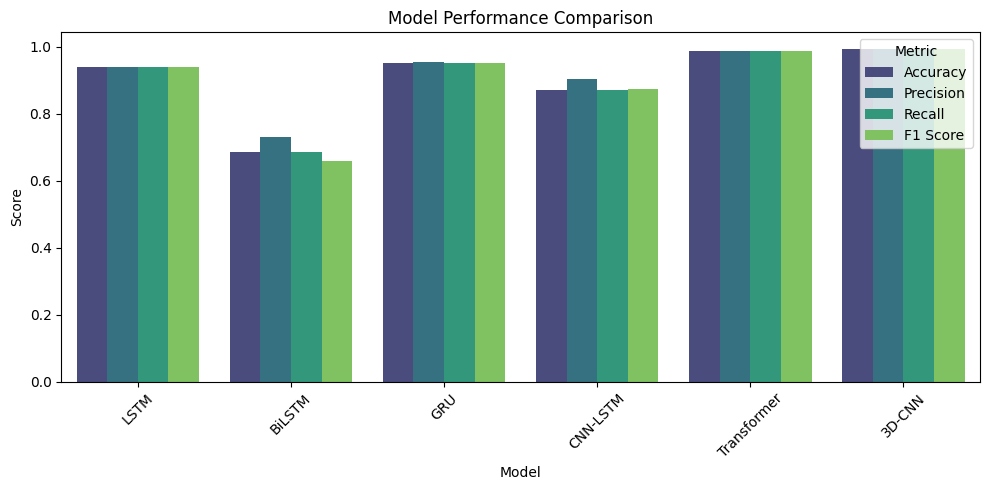


🏆 Best model: 3D-CNN
5/5 [==============================] - 5s 1s/step


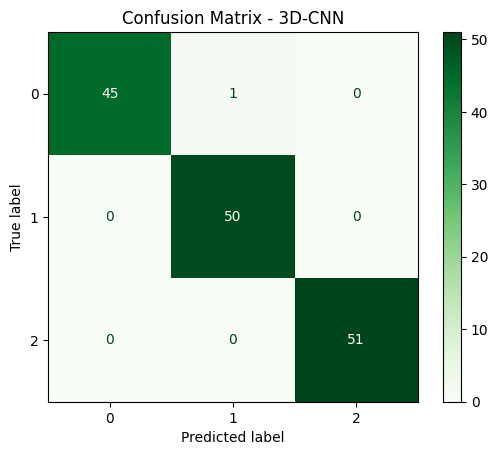

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model

# ==========================================
# 🔹 Step 1: Load All Models
# ==========================================
models_dict = {}
model_paths = {
    "LSTM": "LSTM_regularized_skeletons.h5",
    "BiLSTM": "bilstm_model.h5",
    "GRU": "GRU_regularized_model.h5",
    "CNN-LSTM": "cnn_lstm_model.h5",
    "Transformer": "transformer_asd_model.h5",
    "3D-CNN": "3dcnn_regularized_model.h5",
    "ST-GCN": "stgcn_model.h5"
}

for name, path in model_paths.items():
    try:
        models_dict[name] = load_model(path, compile=False)
        print(f"✅ Loaded {name}")
    except Exception as e:
        print(f"⚠️ Could not load {name}: {e}")

# ==========================================
# 🔹 Step 2: Evaluate Each Model
# ==========================================
results = []
y_true = np.argmax(y_test, axis=1)

for name, model in models_dict.items():
    print(f"\n🔹 Evaluating {name} ...")
    try:
        # Handle input shape differences
        if "3D" in name:
            X_eval = X_test_3d
        elif "ST-GCN" in name:
            X_eval = X_test_stgcn  # Only if available
        else:
            X_eval = X_test
        
        y_pred_probs = model.predict(X_eval)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1 Score": f1
        })
        print(f"{name}: Acc={acc:.3f}, Prec={prec:.3f}, Rec={rec:.3f}, F1={f1:.3f}")

    except Exception as e:
        print(f"❌ Error evaluating {name}: {e}")

# ==========================================
# 🔹 Step 3: Create Comparison DataFrame
# ==========================================
comparison_df = pd.DataFrame(results)
print("\n📊 Model Comparison:")
print(comparison_df)

# ==========================================
# 🔹 Step 4: Plot All Metrics Together
# ==========================================
plt.figure(figsize=(10,5))
sns.barplot(
    data=comparison_df.melt(id_vars="Model", 
                            value_vars=["Accuracy","Precision","Recall","F1 Score"]),
    x="Model", y="value", hue="variable", palette="viridis"
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ==========================================
# 🔹 Step 5: Confusion Matrix for Best Model
# ==========================================
best_model_name = comparison_df.loc[comparison_df["Accuracy"].idxmax(), "Model"]
best_model = models_dict[best_model_name]
print(f"\n🏆 Best model: {best_model_name}")

if "3D" in best_model_name:
    X_eval = X_test_3d
elif "ST-GCN" in best_model_name:
    X_eval = X_test_stgcn
else:
    X_eval = X_test

y_pred_best = np.argmax(best_model.predict(X_eval), axis=1)
cm = confusion_matrix(y_true, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# Real Time Trial

In [1]:
# Skeleton extraction + save (.npy) — robust version
# Works for nested folder structures. Saves no_aug and optional aug versions.

import os
import cv2
import numpy as np
from tqdm import tqdm

# --------- CONFIG ----------
input_dir = r"C:\Users\SATYAM\Downloads\ssbd_dataset\ssbd2"  # 🔁 update if needed
output_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed_new"     # 🔁 update if needed
no_aug_dir = os.path.join(output_dir, "no_aug")
aug_dir = os.path.join(output_dir, "aug")
os.makedirs(no_aug_dir, exist_ok=True)
os.makedirs(aug_dir, exist_ok=True)

TARGET_FRAMES = 150   # number of timesteps per sample (must match training)
NUM_KEYPOINTS = 33    # MediaPipe Pose landmarks count
COORDS = 2            # x,y
AUGMENT = True        # set False to skip augment folder saving
# ---------------------------

# try import mediapipe, give helpful message if not present
try:
    import mediapipe as mp
except Exception as e:
    raise ImportError("mediapipe is required. Install with `pip install mediapipe` and re-run. Error: " + str(e))

mp_pose = mp.solutions.pose
# initialize once and reuse
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

def sample_frame_indices(total_frames, target_frames):
    if total_frames <= 0:
        return np.array([], dtype=int)
    if total_frames <= target_frames:
        # take all frames (will pad later)
        return np.arange(total_frames)
    # evenly spaced indices across the whole video
    return np.linspace(0, total_frames - 1, target_frames, dtype=int)

def extract_skeleton_sequence(video_path, target_frames=TARGET_FRAMES):
    """
    Returns: numpy array of shape (target_frames, NUM_KEYPOINTS, COORDS)
    If absolutely no landmarks detected on any sampled frame -> returns None
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        cap.release()
        return None

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) or 0
    indices = sample_frame_indices(total_frames, target_frames)

    seq = []
    frame_idx = 0
    indices_set = set(indices.tolist())
    # read frames sequentially and process only sampled ones
    success = True
    while success and (len(indices_set) > 0 or frame_idx <= (indices[-1] if len(indices)>0 else -1)):
        success, frame = cap.read()
        if not success:
            break
        if frame_idx in indices_set:
            # process this frame
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb)
            if results.pose_landmarks:
                kp = [[lm.x, lm.y] for lm in results.pose_landmarks.landmark[:NUM_KEYPOINTS]]
                # ensure shape exactly NUM_KEYPOINTS x COORDS
                kp = np.array(kp, dtype=np.float32)
            else:
                kp = np.zeros((NUM_KEYPOINTS, COORDS), dtype=np.float32)
            seq.append(kp)
            indices_set.remove(frame_idx)
        frame_idx += 1

    cap.release()

    # If we didn't get enough sampled frames (e.g., very short video), pad by repeating last available or zeros
    if len(seq) == 0:
        return None  # completely failed (no frames or no landmarks in any sampled frame)

    # pad or trim to exact length
    seq = np.array(seq, dtype=np.float32)
    if seq.shape[0] > target_frames:
        seq = seq[:target_frames]
    elif seq.shape[0] < target_frames:
        last = seq[-1]
        pad_count = target_frames - seq.shape[0]
        padding = np.zeros((pad_count, NUM_KEYPOINTS, COORDS), dtype=np.float32)
        padding[:] = last  # repeat last frame for smoother pad
        seq = np.concatenate([seq, padding], axis=0)

    return seq  # shape (target_frames, NUM_KEYPOINTS, COORDS)


def normalize_skeleton(seq):
    # seq shape: (T, K, 2)
    mean = np.mean(seq, axis=(0,1))
    std = np.std(seq, axis=(0,1)) + 1e-8
    return (seq - mean) / std


def augment_skeleton(seq):
    """Return list of augmented sequences (same shape)."""
    aug_list = []
    # mirrored (flip x)
    mirrored = seq.copy()
    mirrored[:, :, 0] *= -1
    aug_list.append(mirrored)
    # temporal jitter: small random roll
    shift = np.random.randint(-5, 6)
    jitter = np.roll(seq, shift=shift, axis=0)
    aug_list.append(jitter)
    # gaussian noise
    noise = seq + np.random.normal(0, 0.03, seq.shape).astype(np.float32)
    aug_list.append(noise)
    return aug_list


# Walk input_dir and find videos; determine top-level class name (the first path part under input_dir)
saved_count = 0
skipped_count = 0
failed_files = []

# build a list of video files first (robust)
video_exts = ('.mp4', '.avi', '.mov', '.mkv', '.MP4', '.AVI')

video_paths = []
for root, dirs, files in os.walk(input_dir):
    for f in files:
        if f.endswith(video_exts):
            video_paths.append(os.path.join(root, f))

print(f"Found {len(video_paths)} video files under '{input_dir}' — starting extraction...")

for vpath in tqdm(video_paths):
    # class is the first path component under input_dir
    rel = os.path.relpath(vpath, input_dir)
    parts = rel.split(os.sep)
    class_name = parts[0] if len(parts) > 1 else "unknown"
    # create class subdirs in outputs
    out_no_aug_class = os.path.join(no_aug_dir, class_name)
    out_aug_class = os.path.join(aug_dir, class_name)
    os.makedirs(out_no_aug_class, exist_ok=True)
    os.makedirs(out_aug_class, exist_ok=True)

    base_name = os.path.splitext(os.path.basename(vpath))[0]

    try:
        seq = extract_skeleton_sequence(vpath, TARGET_FRAMES)
        if seq is None:
            skipped_count += 1
            failed_files.append(vpath)
            # print(f"Skipped (no landmarks): {vpath}")
            continue

        # normalize
        seq = normalize_skeleton(seq)

        # save no_aug
        save_no_aug = os.path.join(out_no_aug_class, f"{base_name}.npy")
        np.save(save_no_aug, seq)
        saved_count += 1

        # save augmentations (if asked)
        if AUGMENT:
            aug_seqs = augment_skeleton(seq)
            for i, aseq in enumerate(aug_seqs, start=1):
                save_aug = os.path.join(out_aug_class, f"{base_name}_aug{i}.npy")
                np.save(save_aug, aseq)

    except Exception as e:
        skipped_count += 1
        failed_files.append((vpath, str(e)))
        # continue processing others

print("=== Summary ===")
print("Saved (no_aug)     :", saved_count)
print("Skipped / failed   :", skipped_count)
if failed_files:
    print("Example failed file(s):", failed_files[:5])
print("Processed data saved to:", output_dir)

# close mediapipe resources
pose.close()


Found 289 video files under 'C:\Users\SATYAM\Downloads\ssbd_dataset\ssbd2' — starting extraction...


100%|████████████████████████████████████████████████████████████████████████████████| 289/289 [47:45<00:00,  9.92s/it]

=== Summary ===
Saved (no_aug)     : 289
Skipped / failed   : 0
Processed data saved to: C:\Users\SATYAM\Downloads\ssbd_processed_new


In [15]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- Directories ---
base_dir = r"C:\Users\SATYAM\Downloads\ssbd_processed_new"
no_aug_dir = os.path.join(base_dir, "no_aug")
aug_dir = os.path.join(base_dir, "aug")

def load_npy_data(folder):
    X, y = [], []
    for cls in os.listdir(folder):
        class_folder = os.path.join(folder, cls)
        if not os.path.isdir(class_folder):
            continue
        for file in os.listdir(class_folder):
            if file.endswith(".npy"):
                path = os.path.join(class_folder, file)
                X.append(np.load(path))
                y.append(cls)
    return np.array(X), np.array(y)

# Load both no_aug and aug data
X_no_aug, y_no_aug = load_npy_data(no_aug_dir)
X_aug, y_aug = load_npy_data(aug_dir)

# Combine both
X = np.concatenate([X_no_aug, X_aug], axis=0)
y = np.concatenate([y_no_aug, y_aug], axis=0)

print("Total samples:", X.shape[0])
print("Data shape:", X.shape, "| Labels shape:", y.shape)

# Flatten coordinates for GRU input (150, 33, 2) -> (150, 66)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2] * X.shape[3])

# Encode class labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
print("Classes:", encoder.classes_)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")


Total samples: 1156
Data shape: (1156, 150, 33, 2) | Labels shape: (1156,)
Classes: ['Action_videos' 'Still_videos' 'armFlapping' 'headBanging' 'spinning']
Train: (924, 150, 66), Test: (232, 150, 66)


Epoch 1/40
47/47 [==============================] - 21s 199ms/step - loss: 1.5278 - accuracy: 0.3559 - val_loss: 1.2873 - val_accuracy: 0.4703
Epoch 2/40
47/47 [==============================] - 6s 126ms/step - loss: 1.2703 - accuracy: 0.4993 - val_loss: 1.1338 - val_accuracy: 0.5081
Epoch 3/40
47/47 [==============================] - 6s 135ms/step - loss: 1.1060 - accuracy: 0.5697 - val_loss: 0.9802 - val_accuracy: 0.6054
Epoch 4/40
47/47 [==============================] - 6s 136ms/step - loss: 0.9636 - accuracy: 0.6035 - val_loss: 0.8384 - val_accuracy: 0.6378
Epoch 5/40
47/47 [==============================] - 6s 127ms/step - loss: 0.8082 - accuracy: 0.6888 - val_loss: 0.7171 - val_accuracy: 0.6865
Epoch 6/40
47/47 [==============================] - 6s 128ms/step - loss: 0.6659 - accuracy: 0.7361 - val_loss: 0.6379 - val_accuracy: 0.7351
Epoch 7/40
47/47 [==============================] - 7s 149ms/step - loss: 0.5795 - accuracy: 0.7781 - val_loss: 0.5902 - val_accuracy: 0.7459
Epoch

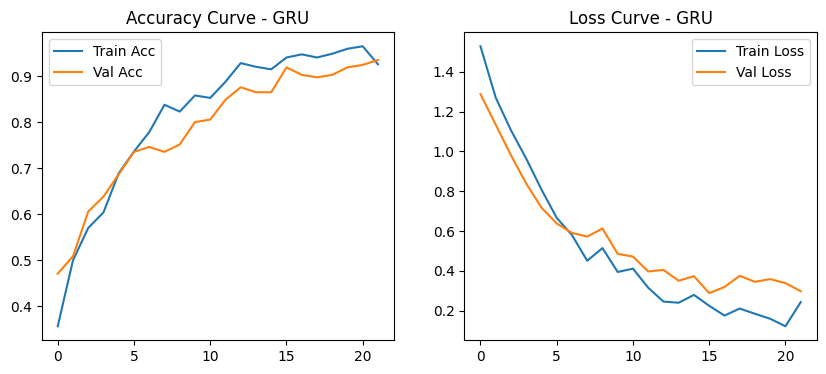

8/8 [==============================] - 3s 42ms/step


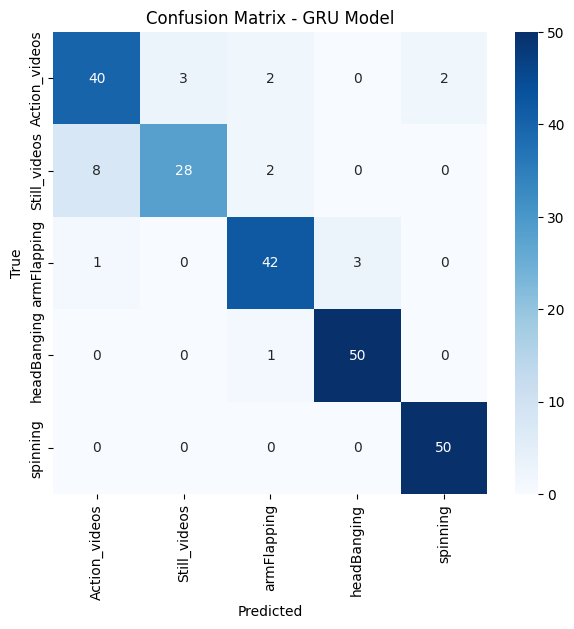


Classification Report:

               precision    recall  f1-score   support

Action_videos       0.82      0.85      0.83        47
 Still_videos       0.90      0.74      0.81        38
  armFlapping       0.89      0.91      0.90        46
  headBanging       0.94      0.98      0.96        51
     spinning       0.96      1.00      0.98        50

     accuracy                           0.91       232
    macro avg       0.90      0.90      0.90       232
 weighted avg       0.91      0.91      0.90       232

💾 Model saved as gru_asd_neutral_model.h5


In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# One-hot encode the labels
num_classes = len(np.unique(y_train))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

# =========================
# Model Definition
# =========================
model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    GRU(64, kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# =========================
# Compile Model
# =========================
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# =========================
# Train Model
# =========================
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=40,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Evaluate on Test Data
# =========================
test_loss, test_acc = model.evaluate(X_test, y_test_cat)
print(f"🧪 Final Test Accuracy: {test_acc*100:.2f}%")

# =========================
# Plot Training Curves
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - GRU")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - GRU")
plt.legend()
plt.show()

# =========================
# Confusion Matrix + Report
# =========================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
classes = encoder.classes_

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - GRU Model")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=classes))

# =========================
# Save Model
# =========================
model.save("gru_asd_neutral_model.h5")
print("💾 Model saved as gru_asd_neutral_model.h5")

Epoch 1/40
47/47 [==============================] - 12s 162ms/step - loss: 1.3908 - accuracy: 0.4235 - val_loss: 1.1004 - val_accuracy: 0.5622
Epoch 2/40
47/47 [==============================] - 6s 119ms/step - loss: 1.0744 - accuracy: 0.5846 - val_loss: 0.9302 - val_accuracy: 0.6541
Epoch 3/40
47/47 [==============================] - 6s 119ms/step - loss: 0.9049 - accuracy: 0.6360 - val_loss: 0.7292 - val_accuracy: 0.6865
Epoch 4/40
47/47 [==============================] - 6s 120ms/step - loss: 0.7051 - accuracy: 0.7199 - val_loss: 0.7294 - val_accuracy: 0.7081
Epoch 5/40
47/47 [==============================] - 6s 124ms/step - loss: 0.6116 - accuracy: 0.7713 - val_loss: 0.7109 - val_accuracy: 0.7676
Epoch 6/40
47/47 [==============================] - 6s 126ms/step - loss: 0.5853 - accuracy: 0.7862 - val_loss: 0.5846 - val_accuracy: 0.7838
Epoch 7/40
47/47 [==============================] - 6s 127ms/step - loss: 0.4805 - accuracy: 0.8336 - val_loss: 0.5158 - val_accuracy: 0.7784
Epoch

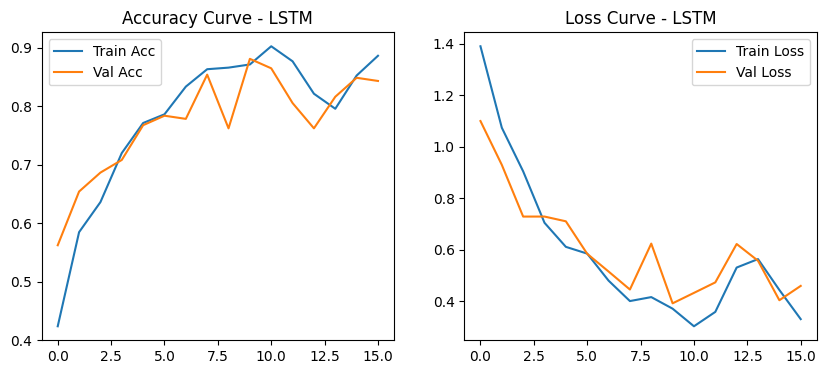

8/8 [==============================] - 2s 46ms/step


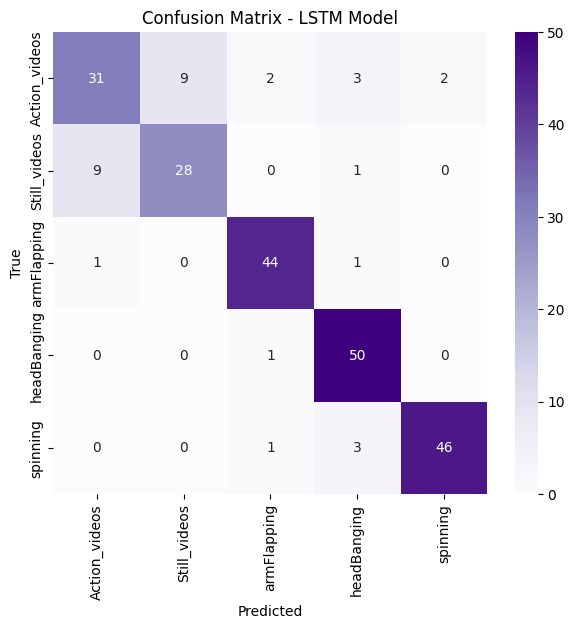


Classification Report:

               precision    recall  f1-score   support

Action_videos       0.76      0.66      0.70        47
 Still_videos       0.76      0.74      0.75        38
  armFlapping       0.92      0.96      0.94        46
  headBanging       0.86      0.98      0.92        51
     spinning       0.96      0.92      0.94        50

     accuracy                           0.86       232
    macro avg       0.85      0.85      0.85       232
 weighted avg       0.85      0.86      0.85       232

💾 Model saved as lstm_asd_neutral_model.h5


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# =========================
# Model Definition
# =========================
lstm_model = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    LSTM(64, kernel_regularizer=l2(1e-4)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# =========================
# Compile Model
# =========================
lstm_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

# =========================
# Train Model
# =========================
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=40,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

# =========================
# Evaluate
# =========================
test_loss, test_acc = lstm_model.evaluate(X_test, y_test_cat)
print(f"🧪 Final Test Accuracy (LSTM): {test_acc*100:.2f}%")

# =========================
# Plot Accuracy and Loss
# =========================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - LSTM")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - LSTM")
plt.legend()
plt.show()

# =========================
# Confusion Matrix + Report
# =========================
y_pred_probs = lstm_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
classes = encoder.classes_

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - LSTM Model")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=classes))

# =========================
# Save Model
# =========================
lstm_model.save("lstm_asd_neutral_model.h5")
print("💾 Model saved as lstm_asd_neutral_model.h5")


✅ Data loaded successfully!
Train shape: (924, 150, 66) | Test shape: (232, 150, 66)
Unique classes: [0 1 2 3 4]
Epoch 1/40
58/58 [==============================] - ETA: 0s - loss: 2.5457 - accuracy: 0.3420
Epoch 1: val_accuracy improved from -inf to 0.52586, saving model to bilstm_best_model.keras
58/58 [==============================] - 61s 631ms/step - loss: 2.5457 - accuracy: 0.3420 - val_loss: 2.1380 - val_accuracy: 0.5259 - lr: 5.0000e-04
Epoch 2/40
58/58 [==============================] - ETA: 0s - loss: 1.9249 - accuracy: 0.5649
Epoch 2: val_accuracy improved from 0.52586 to 0.68103, saving model to bilstm_best_model.keras
58/58 [==============================] - 33s 563ms/step - loss: 1.9249 - accuracy: 0.5649 - val_loss: 1.8230 - val_accuracy: 0.6810 - lr: 5.0000e-04
Epoch 3/40
58/58 [==============================] - ETA: 0s - loss: 1.6738 - accuracy: 0.6602
Epoch 3: val_accuracy improved from 0.68103 to 0.72845, saving model to bilstm_best_model.keras
58/58 [===============

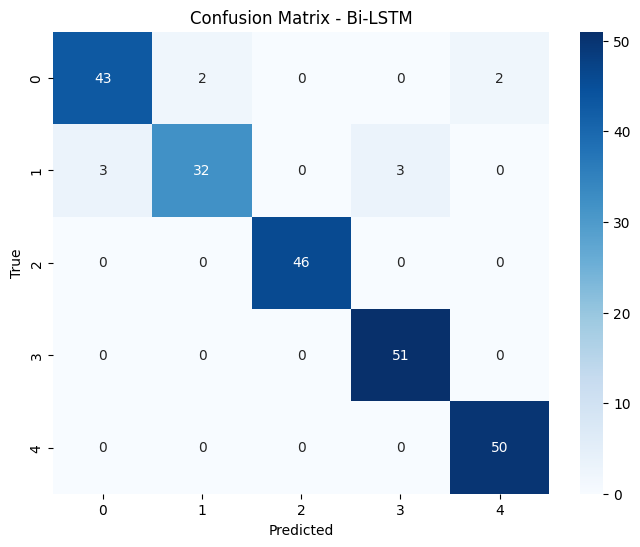


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.91      0.92        47
           1       0.94      0.84      0.89        38
           2       1.00      1.00      1.00        46
           3       0.94      1.00      0.97        51
           4       0.96      1.00      0.98        50

    accuracy                           0.96       232
   macro avg       0.96      0.95      0.95       232
weighted avg       0.96      0.96      0.96       232



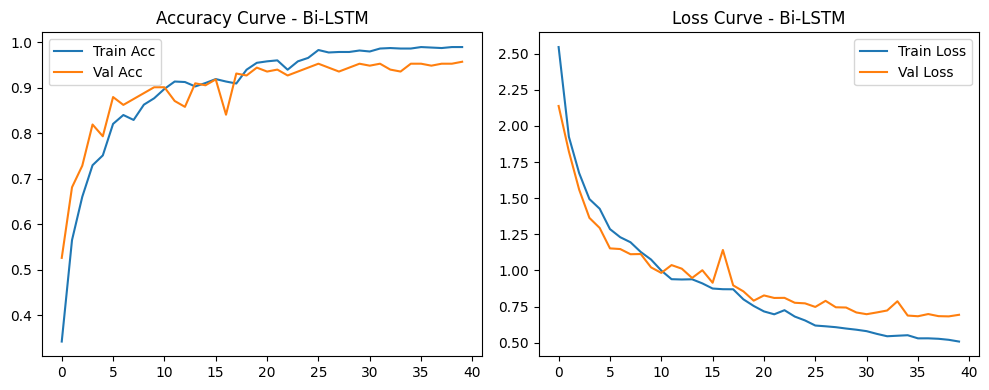

💾 Model saved as BiLSTM_asd_behavior_model.h5


In [4]:
# ===================================================
#  Bi-LSTM Model for ASD Behavior Classification
# ===================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================
# Load processed data
# ===================================================
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")

print("✅ Data loaded successfully!")
print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Unique classes: {np.unique(y_train)}")

# ===================================================
# Encode class labels
# ===================================================
le = LabelEncoder()
y_train_enc = tf.keras.utils.to_categorical(le.fit_transform(y_train))
y_test_enc = tf.keras.utils.to_categorical(le.transform(y_test))

num_classes = y_train_enc.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2])

# ===================================================
# Build BiLSTM Model
# ===================================================
model = Sequential([
    Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=input_shape),
    Dropout(0.4),
    BatchNormalization(),

    Bidirectional(LSTM(64, kernel_regularizer=l2(0.001))),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# ===================================================
# Compile Model
# ===================================================
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ===================================================
# Callbacks
# ===================================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'bilstm_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# ===================================================
# Train Model
# ===================================================
history = model.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=40,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)

# ===================================================
# Evaluate Model
# ===================================================
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# ===================================================
# Confusion Matrix + Classification Report
# ===================================================
# Predict
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# ✅ Fix: convert label classes to strings
classes = [str(c) for c in le.classes_]

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Bi-LSTM")
plt.show()

# Classification Report
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

# ===================================================
# Plot Training Curves
# ===================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - Bi-LSTM")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - Bi-LSTM")
plt.legend()
plt.tight_layout()
plt.show()

# ===================================================
# Save Model
# ===================================================
model.save("BiLSTM_asd_behavior_model.h5")
print("💾 Model saved as BiLSTM_asd_behavior_model.h5")


✅ Data loaded successfully!
Train shape: (924, 150, 66) | Test shape: (232, 150, 66)
Unique classes in training data: [0 1 2 3 4]

Detected Classes: ['0', '1', '2', '3', '4']
Number of classes: 5
Epoch 1/40
58/58 [==============================] - ETA: 0s - loss: 1.9257 - accuracy: 0.3929
Epoch 1: val_accuracy improved from -inf to 0.53879, saving model to cnn_lstm_best_model.keras
58/58 [==============================] - 8s 59ms/step - loss: 1.9257 - accuracy: 0.3929 - val_loss: 1.6959 - val_accuracy: 0.5388 - lr: 5.0000e-04
Epoch 2/40
57/58 [============================>.] - ETA: 0s - loss: 1.5304 - accuracy: 0.5241
Epoch 2: val_accuracy improved from 0.53879 to 0.62069, saving model to cnn_lstm_best_model.keras
58/58 [==============================] - 3s 50ms/step - loss: 1.5283 - accuracy: 0.5227 - val_loss: 1.4130 - val_accuracy: 0.6207 - lr: 5.0000e-04
Epoch 3/40
58/58 [==============================] - ETA: 0s - loss: 1.3465 - accuracy: 0.6180
Epoch 3: val_accuracy improved from

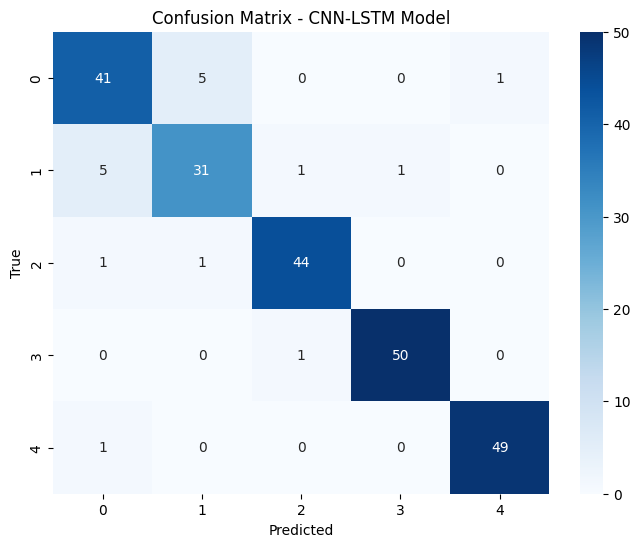


📊 Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        47
           1       0.84      0.82      0.83        38
           2       0.96      0.96      0.96        46
           3       0.98      0.98      0.98        51
           4       0.98      0.98      0.98        50

    accuracy                           0.93       232
   macro avg       0.92      0.92      0.92       232
weighted avg       0.93      0.93      0.93       232



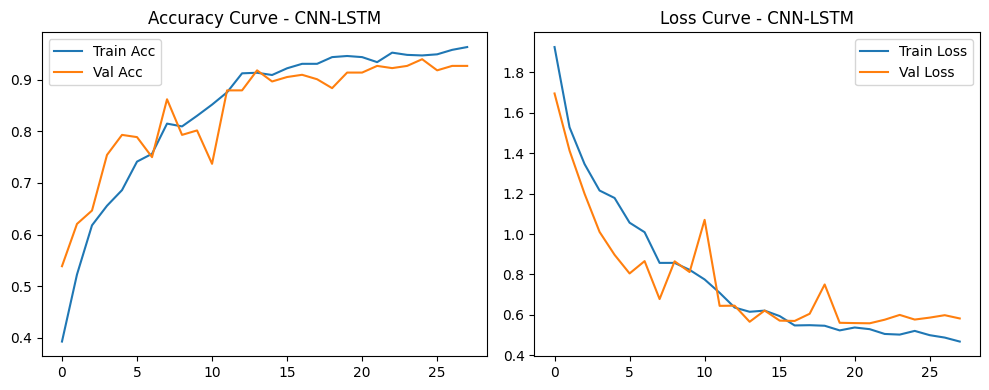

💾 Model saved as CNN_LSTM_asd_behavior_model.h5


In [5]:
# ===================================================
#  CNN-LSTM Model for ASD Behavior Classification
# ===================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================
# Load processed data
# ===================================================
try:
    X_train = np.load("X_train.npy")
    X_test = np.load("X_test.npy")
    y_train = np.load("y_train.npy")
    y_test = np.load("y_test.npy")
    print("✅ Data loaded successfully!")
except FileNotFoundError:
    raise FileNotFoundError("❌ One or more .npy files are missing. Ensure X_train.npy, X_test.npy, y_train.npy, y_test.npy exist.")

print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
print(f"Unique classes in training data: {np.unique(y_train)}")

# ===================================================
# Encode class labels
# ===================================================
le = LabelEncoder()
y_train_enc = tf.keras.utils.to_categorical(le.fit_transform(y_train))
y_test_enc = tf.keras.utils.to_categorical(le.transform(y_test))

num_classes = y_train_enc.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2])

# Convert class names to strings (to avoid sklearn len() error)
class_names = [str(c) for c in le.classes_]
print("\nDetected Classes:", class_names)
print("Number of classes:", num_classes)

# ===================================================
# Build CNN-LSTM Model
# ===================================================
model = Sequential([
    Conv1D(128, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001), input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    Conv1D(64, 3, activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(2),
    Dropout(0.3),

    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    BatchNormalization(),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# ===================================================
# Compile Model
# ===================================================
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ===================================================
# Callbacks
# ===================================================
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'cnn_lstm_best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# ===================================================
# Train Model
# ===================================================
history = model.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=40,
    batch_size=16,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)

# ===================================================
# Evaluate Model
# ===================================================
test_loss, test_acc = model.evaluate(X_test, y_test_enc, verbose=1)
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

# ===================================================
# Confusion Matrix + Classification Report
# ===================================================
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - CNN-LSTM Model")
plt.show()

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# ===================================================
# Plot Training Curves
# ===================================================
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve - CNN-LSTM")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - CNN-LSTM")
plt.legend()
plt.tight_layout()
plt.show()

# ===================================================
# Save Model
# ===================================================
model.save("CNN_LSTM_asd_behavior_model.h5")
print("💾 Model saved as CNN_LSTM_asd_behavior_model.h5")

Data loaded successfully!
Original shape: (289, 150, 33, 2)
Train shape: (231, 150, 33, 2) Test shape: (58, 150, 33, 2)
Number of Classes: 5
Classes: ['Action_videos' 'Still_videos' 'armFlapping' 'headBanging' 'spinning']

Reshaped:
X_train: (231, 150, 33, 2)
X_test: (58, 150, 33, 2)
Model: "ST-GCN_ASD"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 33, 2)  0           []                               
                                ]                                                                 
                                                                                                  
 tf.einsum_3 (TFOpLambda)       (None, 150, 33, 2)   0           ['input_2[0][0]']                
                                                                                                  
 c

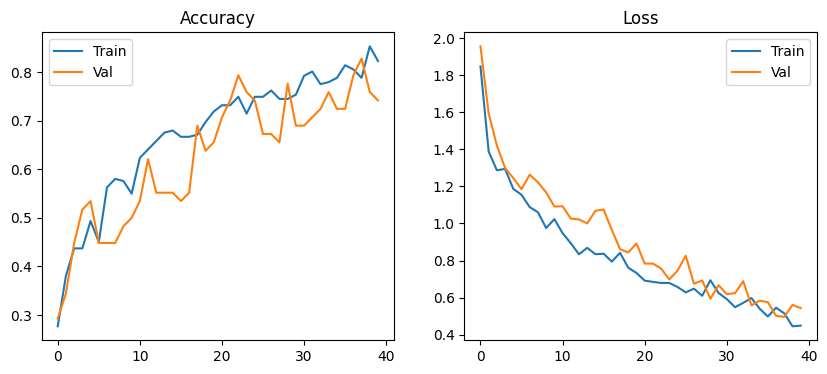

2/2 [==============================] - 7s 3s/step

Classification Report:

               precision    recall  f1-score   support

Action_videos       0.50      0.92      0.65        12
 Still_videos       1.00      0.33      0.50         9
  armFlapping       0.62      0.45      0.53        11
  headBanging       0.92      0.92      0.92        13
     spinning       1.00      0.92      0.96        13

     accuracy                           0.74        58
    macro avg       0.81      0.71      0.71        58
 weighted avg       0.81      0.74      0.73        58



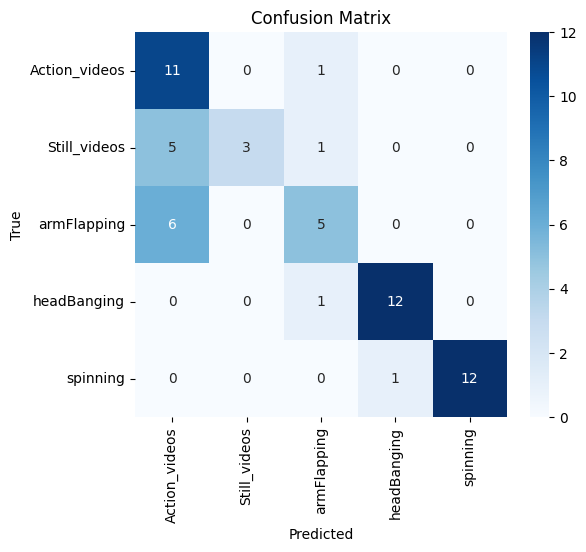


💾 Model saved as stgcn_asd_behavior_model.h5


In [10]:
# ===================================================
# 🧠 ST-GCN for ASD Behavior Classification
# ===================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ===================================================
# 1️⃣ Load Preprocessed Data
# ===================================================

X = np.load("X_data.npy")     # shape: (1156, 150, 66)
y = np.load("y_labels.npy")   # class labels (strings like 'Still_videos', etc.)

print("Data loaded successfully!")
print("Original shape:", X.shape)

# Encode class labels
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(y))
num_classes = y_enc.shape[1]
classes = le.classes_

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Number of Classes:", num_classes)
print("Classes:", classes)

# ===================================================
# 2️⃣ Reshape Input for ST-GCN
# ===================================================
# 66 features = 33 joints × 2 coordinates
num_joints = 33
num_coords = 2

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_joints, num_coords))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], num_joints, num_coords))

print("\nReshaped:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# ===================================================
# 3️⃣ Build Graph Adjacency Matrix (for joints)
# ===================================================

def build_adjacency(num_joints):
    A = np.eye(num_joints)
    for i in range(num_joints - 1):
        A[i, i + 1] = 1
        A[i + 1, i] = 1
    # Simple chain-like adjacency
    return A.astype(np.float32)

A = build_adjacency(num_joints)

# ===================================================
# 4️⃣ Define ST-GCN Building Block
# ===================================================

def st_gcn_block(x, A, out_channels, kernel_size=(3, 3), stride=1, dropout_rate=0.25):
    # Spatial Graph Convolution (approximation)
    x_spatial = tf.einsum('ntvc,vw->ntwc', x, A)  # Aggregate using adjacency
    x_spatial = tf.keras.layers.Conv2D(out_channels, (1, 1), padding='same')(x_spatial)
    
    # Temporal Convolution
    x_temporal = Conv2D(out_channels, kernel_size, strides=(stride, 1), padding='same')(x_spatial)
    x_temporal = BatchNormalization()(x_temporal)
    x_temporal = Activation('relu')(x_temporal)
    x_temporal = Dropout(dropout_rate)(x_temporal)
    
    # Residual connection
    if x.shape[-1] != out_channels:
        x_res = Conv2D(out_channels, (1, 1), padding='same')(x)
    else:
        x_res = x

    x_out = Add()([x_temporal, x_res])
    x_out = Activation('relu')(x_out)
    return x_out

# ===================================================
# 5️⃣ Build ST-GCN Model
# ===================================================

def build_stgcn(input_shape, num_classes, A):
    inputs = Input(shape=input_shape)
    x = st_gcn_block(inputs, A, 64)
    x = st_gcn_block(x, A, 128)
    x = st_gcn_block(x, A, 256)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs, name="ST-GCN_ASD")
    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_stgcn(input_shape, num_classes, A)
model.summary()

# ===================================================
# 6️⃣ Compile Model
# ===================================================

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ===================================================
# 7️⃣ Train Model
# ===================================================

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=16,
    verbose=1
)

# ===================================================
# 8️⃣ Evaluate Model
# ===================================================

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot accuracy/loss
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.show()

# ===================================================
# 9️⃣ Classification Report & Confusion Matrix
# ===================================================

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ===================================================
# 🔟 Save Model
# ===================================================

model.save("stgcn_asd_behavior_model.h5")
print("\n💾 Model saved as stgcn_asd_behavior_model.h5")

Original shapes:
X_train: (924, 150, 66)
X_test: (232, 150, 66)
✅ Reshaped for 3D CNN:
X_train_3d: (924, 150, 66, 1, 1)
X_test_3d: (232, 150, 66, 1, 1)
Num classes: 5
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_22 (Conv3D)          (None, 150, 66, 1, 32)    896       
                                                                 
 batch_normalization_22 (Bat  (None, 150, 66, 1, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_18 (MaxPoolin  (None, 75, 33, 1, 32)    0         
 g3D)                                                            
                                                                 
 dropout_28 (Dropout)        (None, 75, 33, 1, 32)     0         
                                                                 
 conv3d_23 (Conv3D)

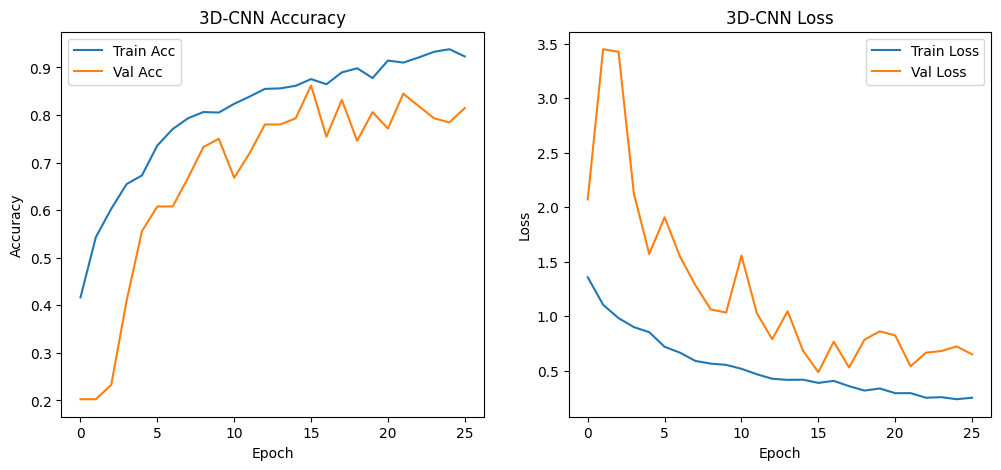

8/8 [==============================] - 4s 488ms/step


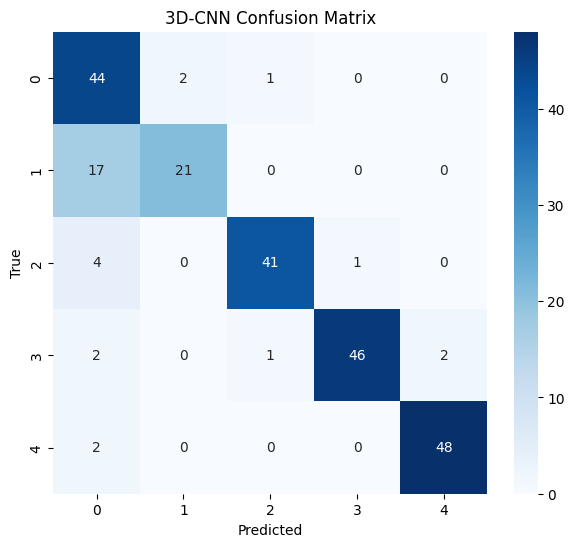


Classification Report:

              precision    recall  f1-score   support

           0       0.64      0.94      0.76        47
           1       0.91      0.55      0.69        38
           2       0.95      0.89      0.92        46
           3       0.98      0.90      0.94        51
           4       0.96      0.96      0.96        50

    accuracy                           0.86       232
   macro avg       0.89      0.85      0.85       232
weighted avg       0.89      0.86      0.86       232



In [10]:
# ===========================================
# 📦 Imports
# ===========================================
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ===========================================
# 🧩 Step 1: Prepare Dataset
# ===========================================
# Assuming X_train, X_test, y_train, y_test already loaded
print("Original shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# Normalize (z-score)
X_train = (X_train - np.mean(X_train)) / (np.std(X_train) + 1e-8)
X_test  = (X_test - np.mean(X_test)) / (np.std(X_test) + 1e-8)

# Reshape for Conv3D: (batch, frames, joints, depth, channels)
X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1, 1))
X_test_3d  = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1, 1))

num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

print("✅ Reshaped for 3D CNN:")
print("X_train_3d:", X_train_3d.shape)
print("X_test_3d:", X_test_3d.shape)
print("Num classes:", num_classes)

# ===========================================
# 🏗️ Step 2: Build 3D-CNN Model
# ===========================================
def build_3dcnn(input_shape, num_classes):
    l2_reg = regularizers.l2(1e-4)
    model = models.Sequential([
        layers.Conv3D(32, (3,3,3), activation='relu', padding='same',
                      kernel_regularizer=l2_reg, input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2,2,1)),
        layers.Dropout(0.2),

        layers.Conv3D(64, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2,2,1)),
        layers.Dropout(0.3),

        layers.Conv3D(128, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.MaxPooling3D((2,2,1)),
        layers.Dropout(0.4),

        layers.Conv3D(256, (3,3,3), activation='relu', padding='same', kernel_regularizer=l2_reg),
        layers.BatchNormalization(),
        layers.GlobalAveragePooling3D(),
        layers.Dropout(0.5),

        layers.Dense(128, activation='relu', kernel_regularizer=l2_reg),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = X_train_3d.shape[1:]
model_3dcnn = build_3dcnn(input_shape, num_classes)
model_3dcnn.summary()

# ===========================================
# ⚙️ Step 3: Callbacks
# ===========================================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
checkpoint = ModelCheckpoint("best_3dcnn_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# ===========================================
# 🏋️ Step 4: Train Model
# ===========================================
history = model_3dcnn.fit(
    X_train_3d, y_train_cat,
    validation_data=(X_test_3d, y_test_cat),
    epochs=60,
    batch_size=8,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=2
)

# ===========================================
# 💾 Step 5: Save Model
# ===========================================
model_3dcnn.save("final_3dcnn_model.h5")
print("✅ Model saved as final_3dcnn_model.h5")

# ===========================================
# 📊 Step 6: Evaluate
# ===========================================
test_loss, test_acc = model_3dcnn.evaluate(X_test_3d, y_test_cat, verbose=0)
print(f"\n🧪 Test Accuracy: {test_acc*100:.2f}% | Loss: {test_loss:.4f}")

# ===========================================
# 📈 Step 7: Plot Metrics
# ===========================================
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("3D-CNN Accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("3D-CNN Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
plt.show()

# ===========================================
# 🧩 Step 8: Confusion Matrix + Report
# ===========================================
y_pred = np.argmax(model_3dcnn.predict(X_test_3d), axis=1)
y_true = np.argmax(y_test_cat, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("3D-CNN Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred))

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks

# Assume you already have:
# X_train, X_test, y_train, y_test
# X_train: (924, 150, 66), X_test: (232, 150, 66)
# y_train, y_test: integer class labels

num_classes = len(np.unique(y_train))
print("Classes:", num_classes)

# Normalize
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
X_test = (X_test - np.min(X_test)) / (np.max(X_test) - np.min(X_test))

# ------------------------------------------------------------------
# 🔹 Transformer Encoder Block (improved)
# ------------------------------------------------------------------
def transformer_encoder(inputs, num_heads, key_dim, ff_dim, dropout=0.1):
    # Multi-Head Attention
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim, dropout=dropout)(inputs, inputs)
    attn_output = layers.Add()([inputs, attn_output])
    attn_output = layers.LayerNormalization(epsilon=1e-6)(attn_output)

    # Feed Forward
    ffn = layers.Dense(ff_dim, activation='relu')(attn_output)
    ffn = layers.Dense(inputs.shape[-1])(ffn)
    ffn_output = layers.Add()([attn_output, ffn])
    return layers.LayerNormalization(epsilon=1e-6)(ffn_output)

# ------------------------------------------------------------------
# 🔹 Model Definition
# ------------------------------------------------------------------
def build_stronger_transformer(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # 1️⃣ 1D Convolution feature extractor
    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
    x = layers.LayerNormalization()(x)

    # 2️⃣ Learnable positional encoding
    seq_len = input_shape[0]
    pos_encoding = tf.Variable(tf.random.normal([seq_len, x.shape[-1]]), trainable=True)
    x = x + pos_encoding

    # 3️⃣ Transformer Encoder Stack
    for _ in range(4):
        x = transformer_encoder(x, num_heads=8, key_dim=64, ff_dim=256, dropout=0.2)

    # 4️⃣ Global average pooling + Dense head
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# ------------------------------------------------------------------
# 🔹 Compile and Train
# ------------------------------------------------------------------
model = build_stronger_transformer((150, 66), num_classes)
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=150,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ------------------------------------------------------------------
# 🔹 Evaluate
# ------------------------------------------------------------------
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")


Classes: 5
Epoch 1/150
58/58 [==============================] - 52s 708ms/step - loss: 1.6758 - accuracy: 0.2348 - val_loss: 1.6422 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 2/150
58/58 [==============================] - 38s 658ms/step - loss: 1.6517 - accuracy: 0.2002 - val_loss: 1.6100 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 3/150
58/58 [==============================] - 39s 672ms/step - loss: 1.6393 - accuracy: 0.1959 - val_loss: 1.6191 - val_accuracy: 0.1983 - lr: 1.0000e-04
Epoch 4/150
58/58 [==============================] - 39s 674ms/step - loss: 1.6272 - accuracy: 0.2035 - val_loss: 1.6065 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 5/150
58/58 [==============================] - 39s 670ms/step - loss: 1.6295 - accuracy: 0.2186 - val_loss: 1.6057 - val_accuracy: 0.2155 - lr: 1.0000e-04
Epoch 6/150
58/58 [==============================] - 39s 670ms/step - loss: 1.6255 - accuracy: 0.1959 - val_loss: 1.6085 - val_accuracy: 0.2198 - lr: 1.0000e-04
Epoch 7/150
58/58 [====

X_test shape: (232, 150, 66)
y_test shape: (232,)

🔹 Evaluating GRU...
8/8 [==============================] - 5s 66ms/step
✅ Accuracy: 90.52%
✅ Precision: 90.51%
✅ Recall: 90.52%
✅ F1-score: 90.35%

Classification Report:
              precision    recall  f1-score   support

           0      0.816     0.851     0.833        47
           1      0.903     0.737     0.812        38
           2      0.894     0.913     0.903        46
           3      0.943     0.980     0.962        51
           4      0.962     1.000     0.980        50

    accuracy                          0.905       232
   macro avg      0.904     0.896     0.898       232
weighted avg      0.905     0.905     0.904       232



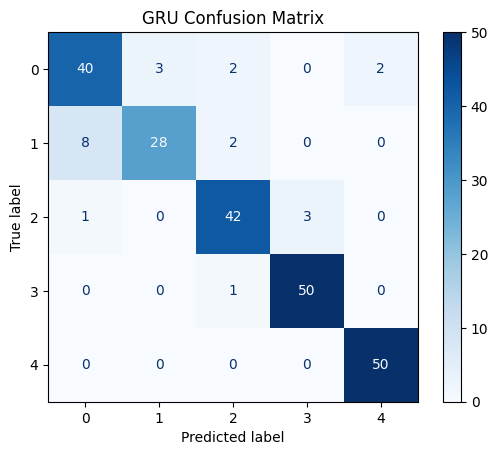


🔹 Evaluating LSTM...
8/8 [==============================] - 4s 88ms/step
✅ Accuracy: 85.78%
✅ Precision: 85.49%
✅ Recall: 85.78%
✅ F1-score: 85.46%

Classification Report:
              precision    recall  f1-score   support

           0      0.756     0.660     0.705        47
           1      0.757     0.737     0.747        38
           2      0.917     0.957     0.936        46
           3      0.862     0.980     0.917        51
           4      0.958     0.920     0.939        50

    accuracy                          0.858       232
   macro avg      0.850     0.851     0.849       232
weighted avg      0.855     0.858     0.855       232



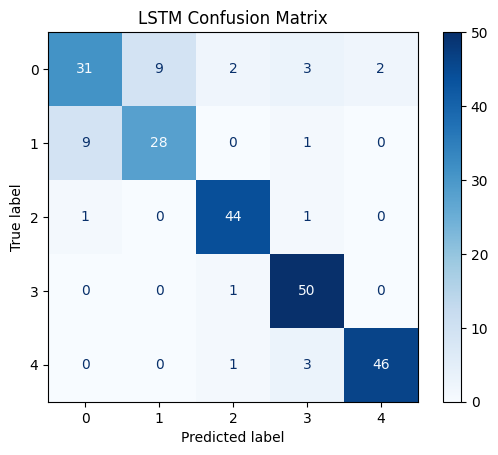


🔹 Evaluating BiLSTM...
8/8 [==============================] - 3s 141ms/step
✅ Accuracy: 95.69%
✅ Precision: 95.67%
✅ Recall: 95.69%
✅ F1-score: 95.60%

Classification Report:
              precision    recall  f1-score   support

           0      0.935     0.915     0.925        47
           1      0.941     0.842     0.889        38
           2      1.000     1.000     1.000        46
           3      0.944     1.000     0.971        51
           4      0.962     1.000     0.980        50

    accuracy                          0.957       232
   macro avg      0.956     0.951     0.953       232
weighted avg      0.957     0.957     0.956       232



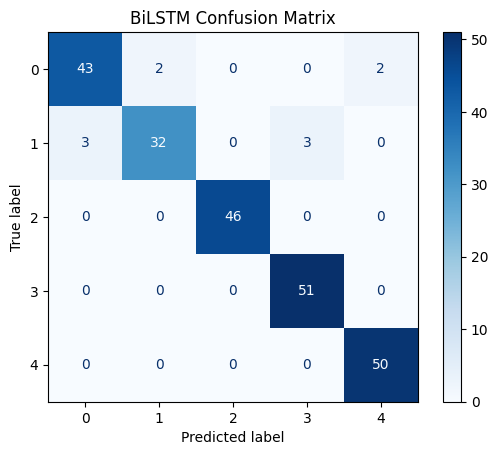


🔹 Evaluating CNN-LSTM...
8/8 [==============================] - 1s 25ms/step
✅ Accuracy: 92.67%
✅ Precision: 92.67%
✅ Recall: 92.67%
✅ F1-score: 92.66%

Classification Report:
              precision    recall  f1-score   support

           0      0.854     0.872     0.863        47
           1      0.838     0.816     0.827        38
           2      0.957     0.957     0.957        46
           3      0.980     0.980     0.980        51
           4      0.980     0.980     0.980        50

    accuracy                          0.927       232
   macro avg      0.922     0.921     0.921       232
weighted avg      0.927     0.927     0.927       232



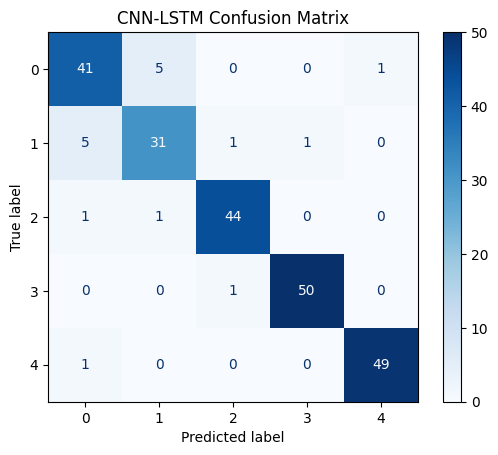


🔹 Evaluating ST-GCN...
⚠️ Error evaluating ST-GCN: Exception encountered when calling layer 'tf.einsum_3' (type TFOpLambda).

Got 0 inputs for equation "ntvc,vw->ntwc", expecting 2

Call arguments received by layer 'tf.einsum_3' (type TFOpLambda):
  • equation='ntvc,vw->ntwc'
  • inputs=<class 'inspect._empty'>
  • kwargs=<class 'inspect._empty'>

🔹 Evaluating 3D-CNN...
8/8 [==============================] - 2s 216ms/step
✅ Accuracy: 86.21%
✅ Precision: 88.98%
✅ Recall: 86.21%
✅ F1-score: 86.24%

Classification Report:
              precision    recall  f1-score   support

           0      0.638     0.936     0.759        47
           1      0.913     0.553     0.689        38
           2      0.953     0.891     0.921        46
           3      0.979     0.902     0.939        51
           4      0.960     0.960     0.960        50

    accuracy                          0.862       232
   macro avg      0.889     0.848     0.853       232
weighted avg      0.890     0.862     0.

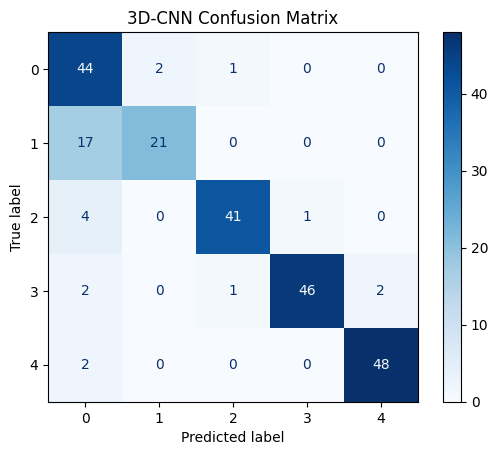


✅ Comparative Results:

      Model  Accuracy  Precision    Recall  F1-Score
0       GRU  0.905172   0.905114  0.905172  0.903507
1      LSTM  0.857759   0.854923  0.857759  0.854649
2    BiLSTM  0.956897   0.956651  0.956897  0.956046
3  CNN-LSTM  0.926724   0.926654  0.926724  0.926645
4    3D-CNN  0.862069   0.889836  0.862069  0.862408


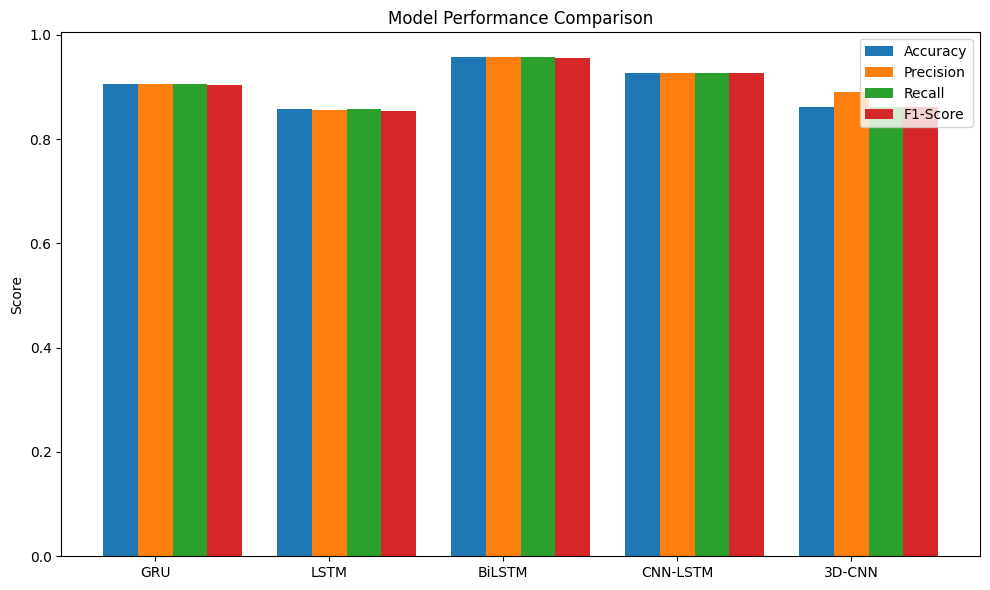

In [19]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# -----------------------------------------------------
# 🔹 Load your test data
# -----------------------------------------------------
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# If labels are one-hot encoded
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

# -----------------------------------------------------
# 🔹 Model filenames
# -----------------------------------------------------
model_files = {
    "GRU":       "gru_asd_neutral_model.h5",
    "LSTM":      "lstm_asd_neutral_model.h5",
    "BiLSTM":    "BiLSTM_asd_behavior_model.h5",
    "CNN-LSTM":  "CNN_LSTM_asd_behavior_model.h5",
    "ST-GCN":    "stgcn_asd_behavior_model.h5",
    "3D-CNN":    "final_3dcnn_model.h5"
}

# -----------------------------------------------------
# 🔹 Custom ST-GCN layer definition
# -----------------------------------------------------
A = np.eye(33, dtype=np.float32)  # replace with your real adjacency

class STGCNLayer(tf.keras.layers.Layer):
    def __init__(self, A, out_channels=64, **kwargs):
        super().__init__(**kwargs)
        self.A = tf.constant(A, dtype=tf.float32)
        self.conv = tf.keras.layers.Conv2D(out_channels, (1, 1), padding='same')

    def call(self, x):
        x_spatial = tf.einsum('ntvc,vw->ntwc', x, self.A)
        return tf.nn.relu(self.conv(x_spatial))

custom_objects = {'STGCNLayer': STGCNLayer}

# -----------------------------------------------------
# 🔹 Evaluate all models
# -----------------------------------------------------
results = []

for name, path in model_files.items():
    print(f"\n🔹 Evaluating {name}...")

    try:
        # Load model
        model = load_model(path, compile=False, custom_objects=custom_objects)

        # Adjust input shape for each model
        if name == "ST-GCN":
            X_input = X_test.reshape((-1, 150, 33, 2))  # Adjust as per your data
        elif name == "3D-CNN":
            X_input = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1, 1))
        else:
            X_input = X_test

        # Predict
        preds = model.predict(X_input, verbose=1)
        y_pred = np.argmax(preds, axis=1)
        y_true = y_test

        # --- Metrics ---
        acc = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        print(f"✅ Accuracy: {acc*100:.2f}%")
        print(f"✅ Precision: {prec*100:.2f}%")
        print(f"✅ Recall: {rec*100:.2f}%")
        print(f"✅ F1-score: {f1*100:.2f}%")

        # Append results
        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision": prec,
            "Recall": rec,
            "F1-Score": f1
        })

        # --- Classification report ---
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, digits=3))

        # --- Confusion matrix ---
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f"{name} Confusion Matrix")
        plt.show()

    except Exception as e:
        print(f"⚠️ Error evaluating {name}: {e}")

# -----------------------------------------------------
# 🔹 Tabulate results
# -----------------------------------------------------
if results:
    results_df = pd.DataFrame(results)
    print("\n✅ Comparative Results:\n")
    print(results_df)

    # -----------------------------------------------------
    # 🔹 Plot comparison graph
    # -----------------------------------------------------
    plt.figure(figsize=(10, 6))
    bar_width = 0.2
    indices = np.arange(len(results_df))

    plt.bar(indices, results_df['Accuracy'], bar_width, label='Accuracy')
    plt.bar(indices + bar_width, results_df['Precision'], bar_width, label='Precision')
    plt.bar(indices + 2 * bar_width, results_df['Recall'], bar_width, label='Recall')
    plt.bar(indices + 3 * bar_width, results_df['F1-Score'], bar_width, label='F1-Score')

    plt.xticks(indices + bar_width, results_df['Model'])
    plt.ylabel("Score")
    plt.title("Model Performance Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ No valid results were collected. Check for model loading or shape errors.")


Data loaded successfully!
Original shape: (289, 150, 33, 2)
Train shape: (231, 150, 33, 2) Test shape: (58, 150, 33, 2)
Number of Classes: 5
Classes: ['Action_videos' 'Still_videos' 'armFlapping' 'headBanging' 'spinning']

Reshaped:
X_train: (231, 150, 33, 2)
X_test: (58, 150, 33, 2)
Model: "STGCN_ASD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 33, 2)]      0         
                                                                 
 stgcn_block_10 (STGCNBlock)  (None, 150, 33, 64)      12992     
                                                                 
 stgcn_block_11 (STGCNBlock)  (None, 150, 33, 128)     66432     
                                                                 
 stgcn_block_12 (STGCNBlock)  (None, 150, 33, 256)     263936    
                                                                 
 global_average_pooling2d_1   (None,

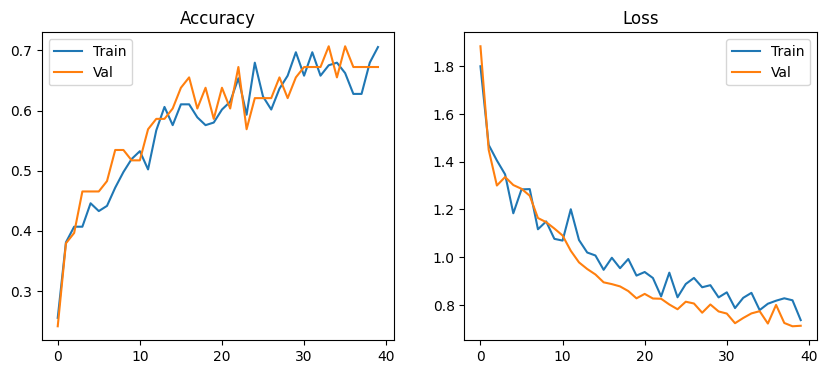

2/2 [==============================] - 2s 622ms/step

Classification Report:

               precision    recall  f1-score   support

Action_videos       0.60      0.50      0.55        12
 Still_videos       0.42      0.56      0.48         9
  armFlapping       0.55      0.55      0.55        11
  headBanging       0.85      0.85      0.85        13
     spinning       0.92      0.85      0.88        13

     accuracy                           0.67        58
    macro avg       0.66      0.66      0.66        58
 weighted avg       0.69      0.67      0.68        58



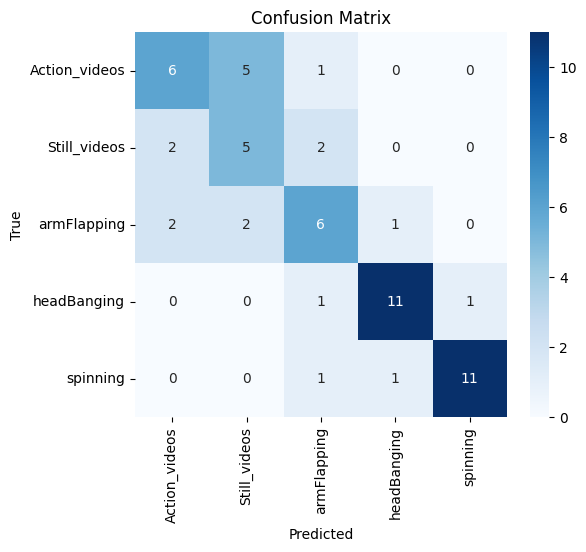

INFO:tensorflow:Assets written to: stgcn_asd_new_behavior_model\assets


INFO:tensorflow:Assets written to: stgcn_asd_new_behavior_model\assets



💾 Model saved as stgcn_asd_new_behavior_model/


In [6]:
# ===================================================
# 🧠 ST-GCN for ASD Behavior Classification (Fixed + Stable)
# ===================================================

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation, Add, Dense,
    Dropout, GlobalAveragePooling2D, Layer
)
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ===================================================
# 1️⃣ Load Preprocessed Data
# ===================================================

X = np.load("X_data.npy")     # shape: (samples, frames, features)
y = np.load("y_labels.npy")

print("Data loaded successfully!")
print("Original shape:", X.shape)

# Encode class labels
le = LabelEncoder()
y_enc = to_categorical(le.fit_transform(y))
num_classes = y_enc.shape[1]
classes = le.classes_

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Number of Classes:", num_classes)
print("Classes:", classes)

# ===================================================
# 2️⃣ Reshape Input for ST-GCN
# ===================================================

num_joints = 33
num_coords = 2
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], num_joints, num_coords))
X_test  = X_test.reshape((X_test.shape[0], X_test.shape[1], num_joints, num_coords))

print("\nReshaped:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

# ===================================================
# 3️⃣ Build Graph Adjacency Matrix
# ===================================================

def build_adjacency(num_joints):
    A = np.eye(num_joints)
    for i in range(num_joints - 1):
        A[i, i + 1] = 1
        A[i + 1, i] = 1
    return tf.constant(A, dtype=tf.float32)

A = build_adjacency(num_joints)

# ===================================================
# 4️⃣ Define ST-GCN Block
# ===================================================

class STGCNBlock(Layer):
    def __init__(self, out_channels, A, stride=1, dropout_rate=0.3):
        super(STGCNBlock, self).__init__()
        self.out_channels = out_channels
        self.A = A
        self.stride = stride
        self.dropout_rate = dropout_rate

        # Define layers once
        self.conv_spatial = Conv2D(out_channels, (1, 1), padding='same')
        self.conv_temporal = Conv2D(out_channels, (3, 1), strides=(stride, 1), padding='same')
        self.bn = BatchNormalization()
        self.drop = Dropout(dropout_rate)
        self.relu = Activation('relu')
        self.res_conv = Conv2D(out_channels, (1, 1), padding='same')

    def call(self, x):
        # Spatial Graph Convolution
        x_spatial = tf.einsum('ntvc,vw->ntwc', x, self.A)
        x_spatial = self.conv_spatial(x_spatial)

        # Temporal Convolution
        x_temporal = self.conv_temporal(x_spatial)
        x_temporal = self.bn(x_temporal)
        x_temporal = self.relu(x_temporal)
        x_temporal = self.drop(x_temporal)

        # Residual connection
        x_res = self.res_conv(x)
        x_out = Add()([x_temporal, x_res])
        return self.relu(x_out)

# ===================================================
# 5️⃣ Build ST-GCN Model
# ===================================================

def build_stgcn(input_shape, num_classes, A):
    inputs = Input(shape=input_shape)
    x = STGCNBlock(64, A)(inputs)
    x = STGCNBlock(128, A)(x)
    x = STGCNBlock(256, A)(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name="STGCN_ASD")
    return model

input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3])
model = build_stgcn(input_shape, num_classes, A)
model.summary()

# ===================================================
# 6️⃣ Compile Model
# ===================================================

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ===================================================
# 7️⃣ Train Model
# ===================================================

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=8,
    verbose=1,
    callbacks=[early_stop]
)

# ===================================================
# 8️⃣ Evaluate Model
# ===================================================

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n✅ Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# ===================================================
# 9️⃣ Visualization
# ===================================================

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss")
plt.legend()
plt.show()

# ===================================================
# 🔟 Classification Report & Confusion Matrix
# ===================================================

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ===================================================
# 💾 Save Model (TensorFlow Format)
# ===================================================

save_path = "stgcn_asd_new_behavior_model"
if os.path.exists(save_path):
    import shutil; shutil.rmtree(save_path)
model.save(save_path, save_format="tf")
print(f"\n💾 Model saved as {save_path}/")

In [ ]:
# MediaPipe Pose 33-keypoint adjacency list
mediapipe_edges = [
    (0, 1), (1, 2), (2, 3), (3, 7),              # Face / head
    (0, 4), (4, 5), (5, 6), (6, 8),              # Other side of face
    (9, 10),                                     # Shoulders
    (11, 12), (11, 13), (13, 15), (12, 14), (14, 16),  # Arms
    (11, 23), (12, 24), (23, 24),                # Torso
    (23, 25), (25, 27), (24, 26), (26, 28),      # Legs
    (27, 29), (29, 31), (28, 30), (30, 32)       # Feet
]
import numpy as np

def build_mediapipe_adjacency(num_joints=33, edges=None):
    if edges is None:
        edges = mediapipe_edges
    A = np.zeros((num_joints, num_joints))
    for i, j in edges:
        A[i, j] = 1
        A[j, i] = 1  # symmetric (undirected)
    return A

A = build_mediapipe_adjacency()
print("Adjacency matrix shape:", A.shape)


In [2]:
import cv2
import mediapipe as mp
import numpy as np
from collections import deque
from tensorflow.keras.models import load_model

# ==============================
# 🔹 Load Trained GRU Model
# ==============================
model = load_model("CNN_LSTM_behavior_model.h5")
actions = ["spinning", "headBanging", "armFlapping", "Action_videos", "Still_videos"]  # Update with your actual class names

# ==============================
# 🔹 Initialize MediaPipe Pose
# ==============================
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5)

# ==============================
# 🔹 Video Capture Setup
# ==============================
cap = cv2.VideoCapture(0)  # 0 = default webcam
sequence_length = 150
frame_buffer = deque(maxlen=sequence_length)

print("🎥 Starting Real-Time GRU Inference... Press 'q' to quit.")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Flip horizontally for natural selfie view
    frame = cv2.flip(frame, 1)
    h, w, _ = frame.shape

    # Convert to RGB for MediaPipe
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(img_rgb)

    # Extract landmarks if detected
    if result.pose_landmarks:
        landmarks = result.pose_landmarks.landmark
        keypoints = np.array([[lm.x, lm.y] for lm in landmarks], dtype=np.float32)
        frame_buffer.append(keypoints)

        # Draw skeleton on frame
        mp.solutions.drawing_utils.draw_landmarks(
            frame, result.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        # Only predict when buffer is full
        if len(frame_buffer) == sequence_length:
            input_data = np.array(frame_buffer).reshape(1, sequence_length, 33 * 2)
            pred = model.predict(input_data)
            action_label = actions[np.argmax(pred)]

            # Display Prediction
            cv2.putText(frame, f"Action: {action_label}", (20, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show video feed
    cv2.imshow('Real-Time GRU Action Recognition', frame)

    # Exit on 'q' key
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
pose.close()

🎥 Starting Real-Time GRU Inference... Press 'q' to quit.
1/1 [==============================] - 0s 21ms/step


In [6]:
import os
from collections import Counter

base_dir = r"C:\Users\SATYAM\Downloads\ssbd_dataset\ssbd2"
classes = os.listdir(base_dir)
counts = {cls: len(os.listdir(os.path.join(base_dir, cls))) for cls in classes}
print(counts)


{'armFlapping': 1, 'headBanging': 1, 'spinning': 1}
